In [16]:
import numpy as np
import xarray as xr
import re
from pathlib import Path
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.font_manager as fm
# import seaborn as sns
import pandas as pd
import os
import pickle
#sns.set_style("dark")
from utils import *

In [17]:
# CONFIGURE SCRIPT
# Where to find Alchemist data files
directory = '../data'
# Where to save charts
output_directory = '../charts/custom-charts'
# How to name the summary of the processed data
pickleOutput = 'data_summary'
# Experiment prefixes: one per experiment (root of the file name)
experiments = ['load_based']
floatPrecision = '{: 0.3f}'
# Number of time samples 
timeSamples = 1440
# time management
minTime = 60
maxTime = 3600
timeColumnName = 'time'
logarithmicTime = False
excludeVariables = []
# One or more variables are considered random and "flattened"
seedVars = ['random']
# Label mapping

In [18]:
if os.path.exists(directory):
    newestFileTime = max([os.path.getmtime(directory + '/' + file) for file in os.listdir(directory)], default=0.0)
    try:
        lastTimeProcessed = pickle.load(open('timeprocessed', 'rb'))
    except:
        lastTimeProcessed = -1
    shouldRecompute = not os.path.exists(".skip_data_process") and newestFileTime != lastTimeProcessed
    if not shouldRecompute:
        try:
            means = pickle.load(open(pickleOutput + '_mean', 'rb'))
            stdevs = pickle.load(open(pickleOutput + '_std', 'rb'))
        except:
            shouldRecompute = True
    if shouldRecompute:
        timefun = np.logspace if logarithmicTime else np.linspace
        means = {}
        stdevs = {}
        for experiment in experiments:
            # Collect all files for the experiment of interest
            import fnmatch
            allfiles = filter(lambda file: fnmatch.fnmatch(file, experiment + '_*.csv'), os.listdir(directory))
            allfiles = [directory + '/' + name for name in allfiles]
            allfiles.sort()
            # From the file name, extract the independent variables
            dimensions = {}
            for file in allfiles:
                dimensions = mergeDicts(dimensions, extractCoordinates(file, excludeVariables))
            dimensions = {k: sorted(v) for k, v in dimensions.items()}
            # Add time to the independent variables
            dimensions[timeColumnName] = range(0, timeSamples)
            print(dimensions)
            # Compute the matrix shape
            shape = tuple(len(v) for k, v in dimensions.items())
            # Prepare the Dataset
            dataset = xr.Dataset()
            for k, v in dimensions.items():
                dataset.coords[k] = v
            if len(allfiles) == 0:
                print("WARNING: No data for experiment " + experiment)
                means[experiment] = dataset
                stdevs[experiment] = xr.Dataset()
            else:
                varNames = extractVariableNames(allfiles[0])
                for v in varNames:
                    if v != timeColumnName:
                        novals = np.ndarray(shape)
                        novals.fill(float('nan'))
                        dataset[v] = (dimensions.keys(), novals)
                # Compute maximum and minimum time, create the resample
                timeColumn = varNames.index(timeColumnName)
                allData = { file: np.matrix(openCsv(file)) for file in allfiles }
                computeMin = minTime is None
                computeMax = maxTime is None
                if computeMax:
                    maxTime = float('-inf')
                    for data in allData.values():
                        maxTime = max(maxTime, data[-1, timeColumn])
                if computeMin:
                    minTime = float('inf')
                    for data in allData.values():
                        minTime = min(minTime, data[0, timeColumn])
                timeline = timefun(minTime, maxTime, timeSamples)
                # Resample
                for file in allData:
#                    print(file)
                    allData[file] = convert(timeColumn, timeline, allData[file])
                # Populate the dataset
                for file, data in allData.items():
                    dataset[timeColumnName] = timeline
                    for idx, v in enumerate(varNames):
                        if v != timeColumnName:
                            darray = dataset[v]
                            experimentVars = extractCoordinates(file, excludeVariables)
                            darray.loc[experimentVars] = data[:, idx].A1
                # Fold the dataset along the seed variables, producing the mean and stdev datasets
                mergingVariables = [seed for seed in seedVars if seed in dataset.coords]
                means[experiment] = dataset.mean(dim = mergingVariables, skipna=True)
                stdevs[experiment] = dataset.std(dim = mergingVariables, skipna=True)
        # Save the datasets
        pickle.dump(means, open(pickleOutput + '_mean', 'wb'), protocol=-1)
        pickle.dump(stdevs, open(pickleOutput + '_std', 'wb'), protocol=-1)
        pickle.dump(newestFileTime, open('timeprocessed', 'wb'))
else:
    means = { experiment: xr.Dataset() for experiment in experiments }
    stdevs = { experiment: xr.Dataset() for experiment in experiments }

# QoS Analysis for load balancing scenario

## Lobster network

In [19]:
dataset = means['load_based']
stdevs = stdevs['load_based']
dataset

<xarray.Dataset> Size: 8MB
Dimensions:              (network: 2, load: 2, computationalCost: 3,
                          devices: 3, behavior: 2, simulationSeconds: 1,
                          time: 1440)
Coordinates:
  * network              (network) <U8 64B 'barabasi' 'lobster'
  * load                 (load) float64 16B 0.0 1.0
  * computationalCost    (computationalCost) float64 24B 1.0 3.0 10.0
  * devices              (devices) float64 24B 25.0 100.0 1e+03
  * behavior             (behavior) <U8 64B 'advanced' 'simple'
  * simulationSeconds    (simulationSeconds) float64 8B 3.6e+03
  * time                 (time) float64 12kB 60.0 62.46 ... 3.598e+03 3.6e+03
Data variables:
    canOffload[sum]      (network, load, computationalCost, devices, behavior, simulationSeconds, time) float64 829kB ...
    wantToOffload[sum]   (network, load, computationalCost, devices, behavior, simulationSeconds, time) float64 829kB ...
    qos                  (network, load, computationalCost, devices, behavior, simulationSeconds, time) float64 829kB ...
    effectiveLoad[mean]  (network, load, computationalCost, devices, behavior, simulationSeconds, time) float64 829kB ...
    effectiveLoad[max]   (network, load, computationalCost, devices, behavior, simulationSeconds, time) float64 829kB ...
    effectiveLoad[min]   (network, load, computationalCost, devices, behavior, simulationSeconds, time) float64 829kB ...
    load[mean]           (network, load, computationalCost, devices, behavior, simulationSeconds, time) float64 829kB ...
    latency[mean]        (network, load, computationalCost, devices, behavior, simulationSeconds, time) float64 829kB ...
    latency[max]         (network, load, computationalCost, devices, behavior, simulationSeconds, time) float64 829kB ...
    latency[min]         (network, load, computationalCost, devices, behavior, simulationSeconds, time) float64 829kB ...

In [20]:
lobster = dataset.sel({"network": "lobster", "simulationSeconds": 3600.0 }, drop=True)
lobster_stdevs = stdevs.sel({"network": "lobster", "simulationSeconds": 3600.0 }, drop=True)

barabasi = dataset.sel({"network": "barabasi", "simulationSeconds": 3600.0 }, drop=True)
barabasi_stdevs = stdevs.sel({"network": "barabasi", "simulationSeconds": 3600.0 }, drop=True)

In [21]:
def extract_values(dataset, stdevs, behaviour, computational_cost, devices, load):
    values = dataset.sel({"behavior": behaviour, "computationalCost": computational_cost, "devices": devices, "load": load }, drop=True)["qos"].to_numpy()
    errors = stdevs.sel({"behavior": behaviour, "computationalCost": computational_cost, "devices": devices, "load": load }, drop=True)["canOffload[sum]"].to_numpy() / devices
    plus_errors = values + errors
    minus_errors = values - errors
    return (values, plus_errors, minus_errors)

In [22]:
import matplotlib.cm as cmx

cmx.viridis(1)

(0.26851, 0.009605, 0.335427, 1.0)

/home/nicolas/Documents/repos/reconfiguration-experiments/data-visualization/env/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


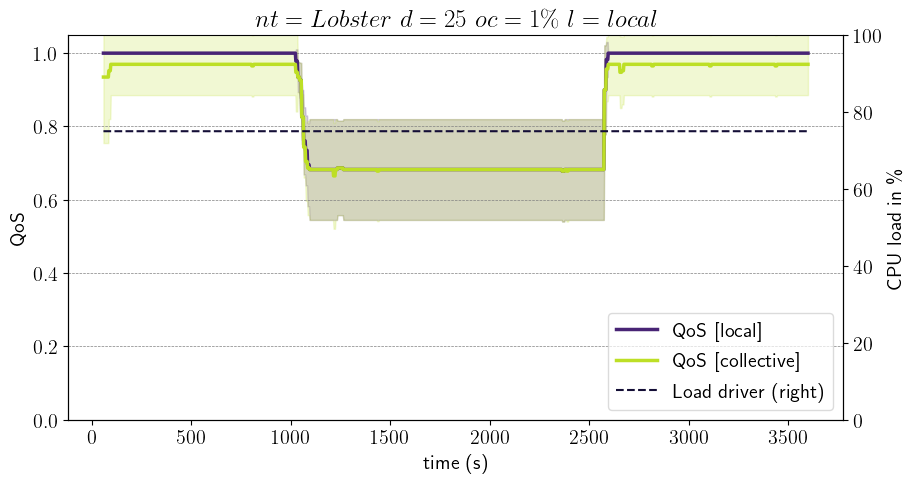

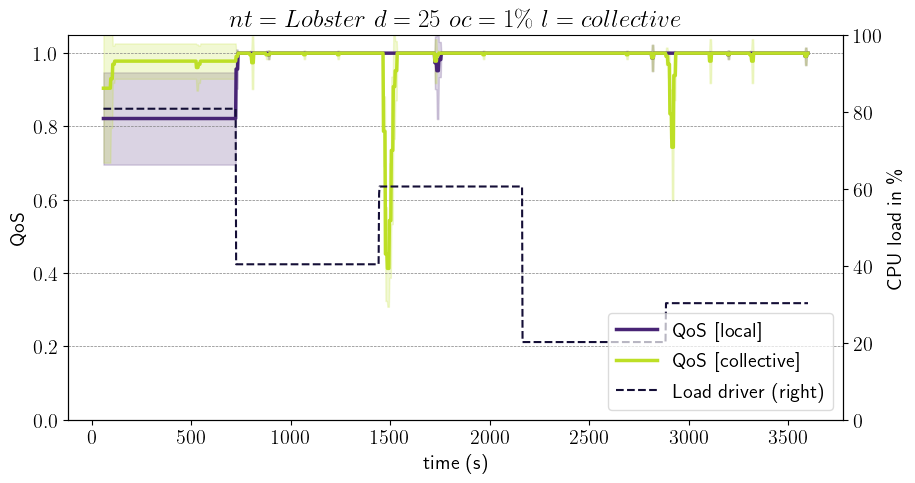

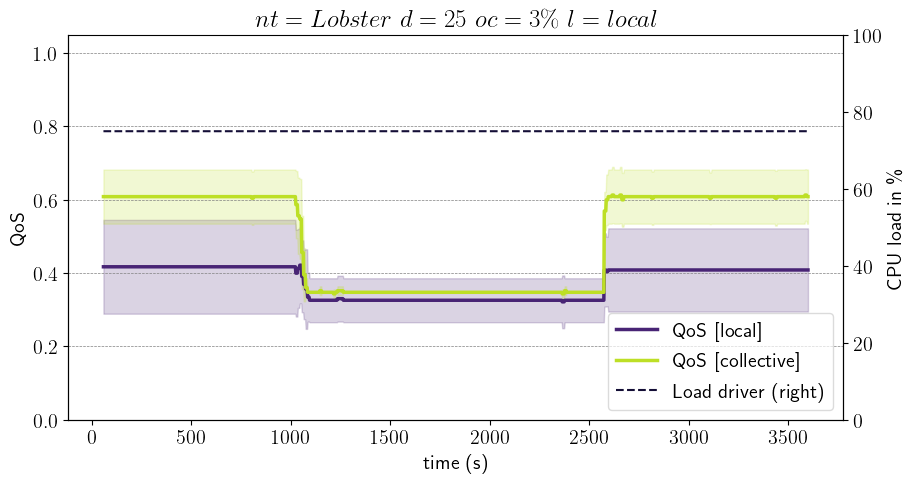

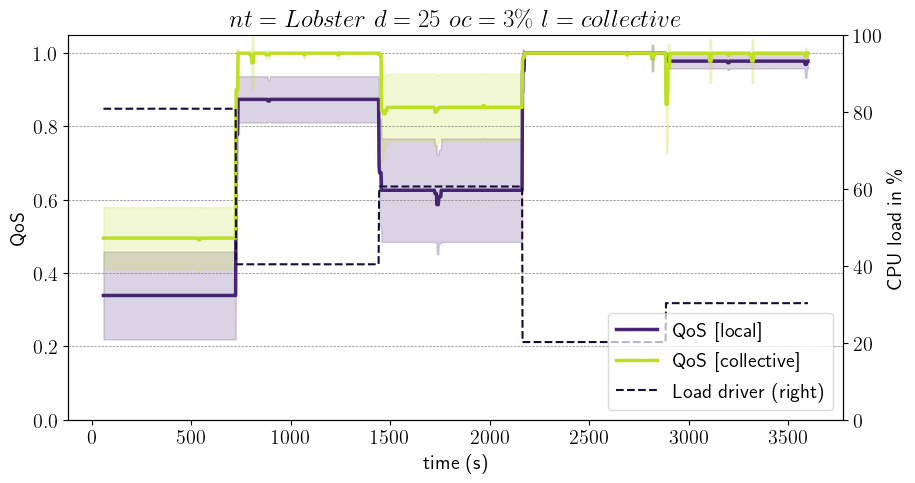

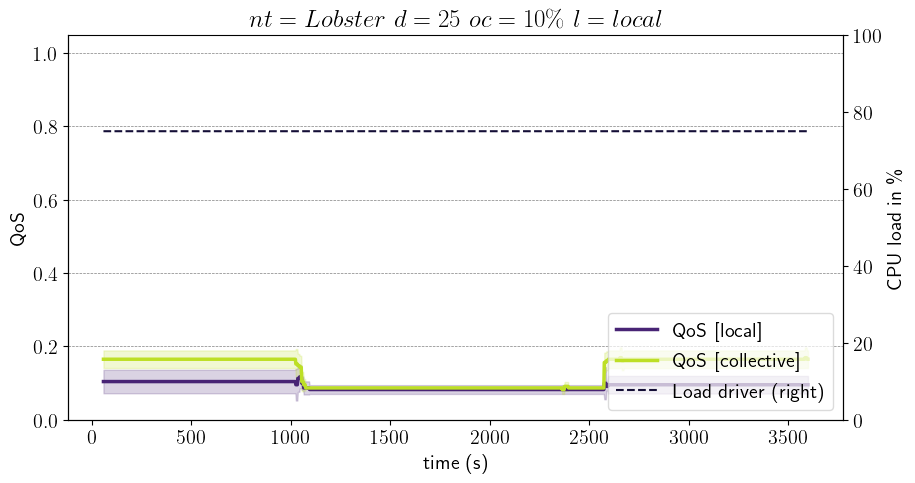

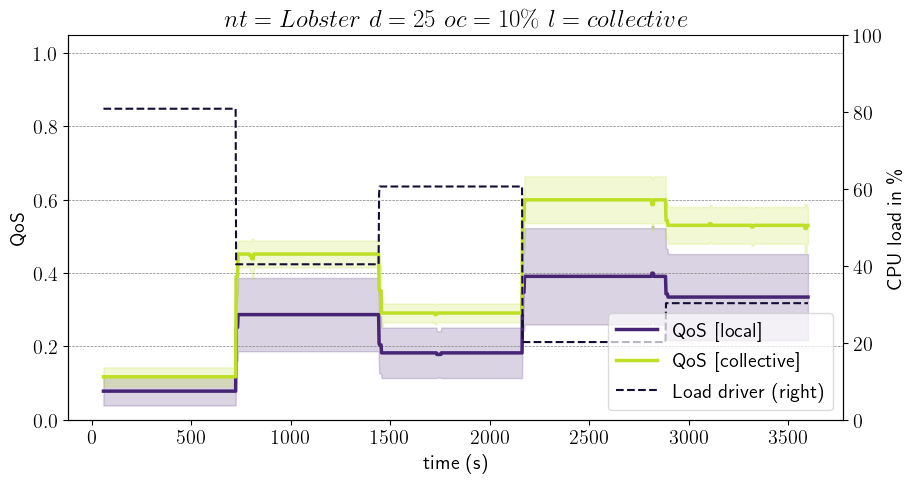

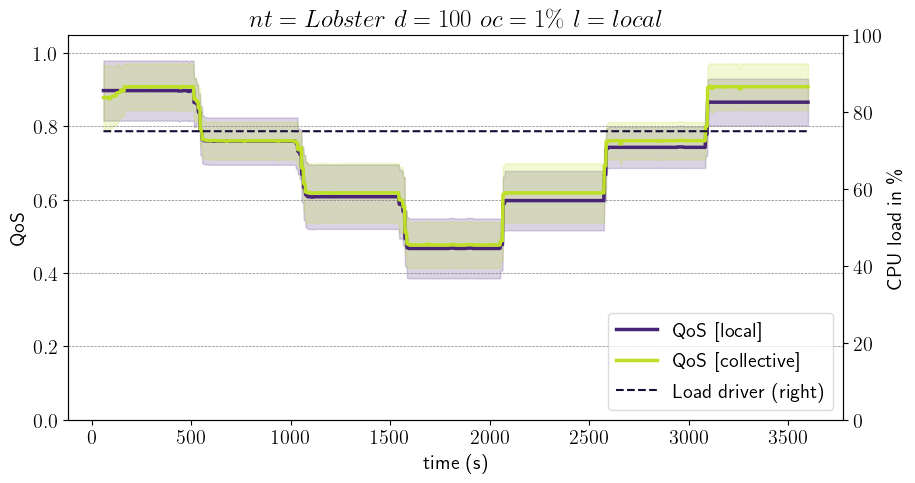

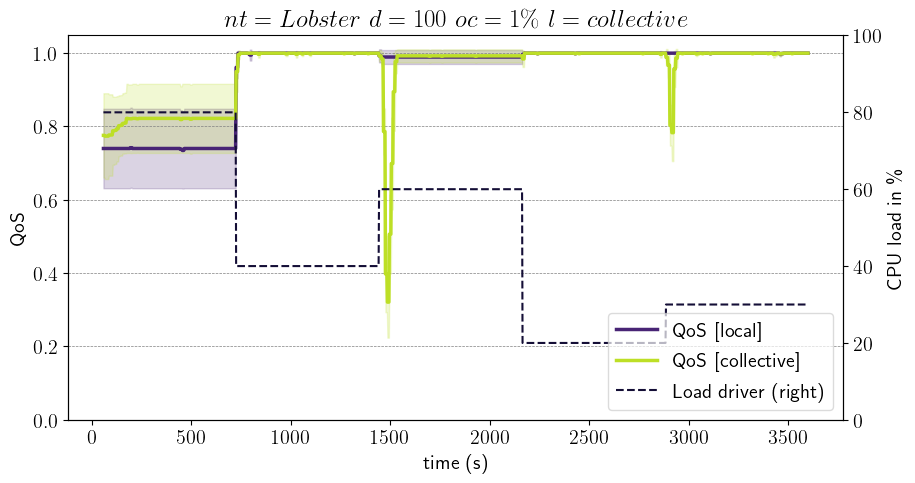

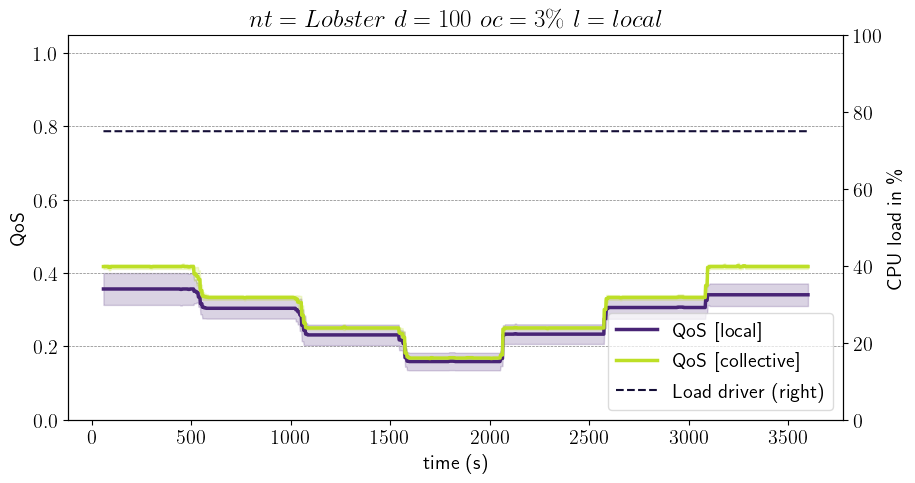

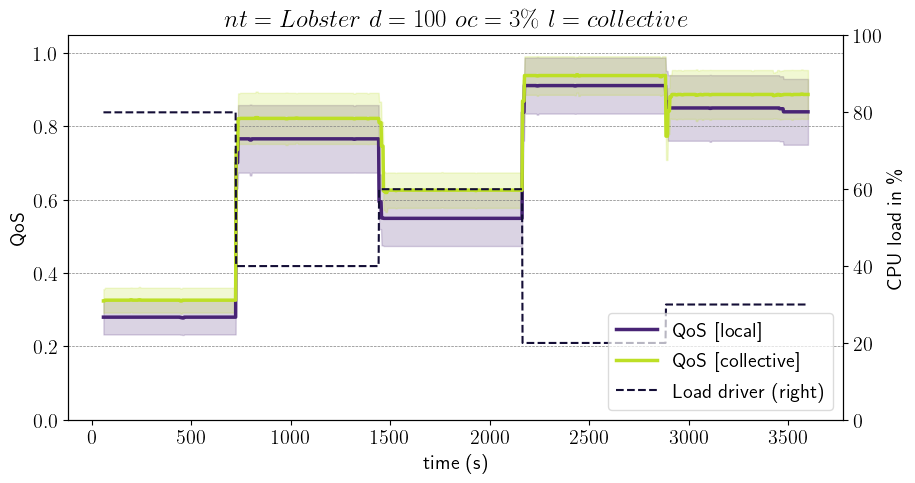

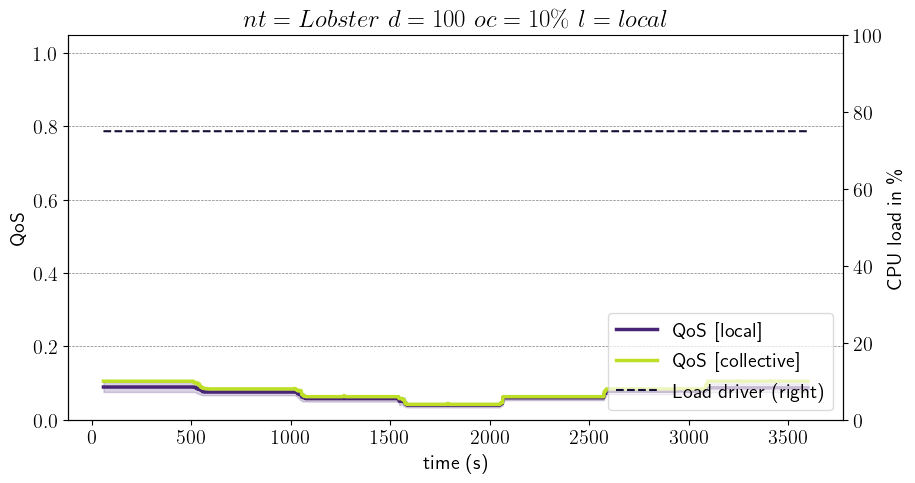

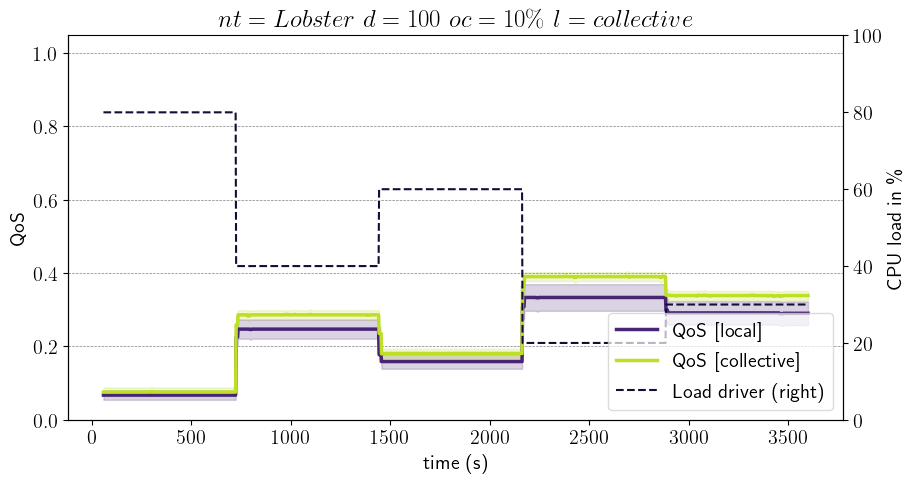

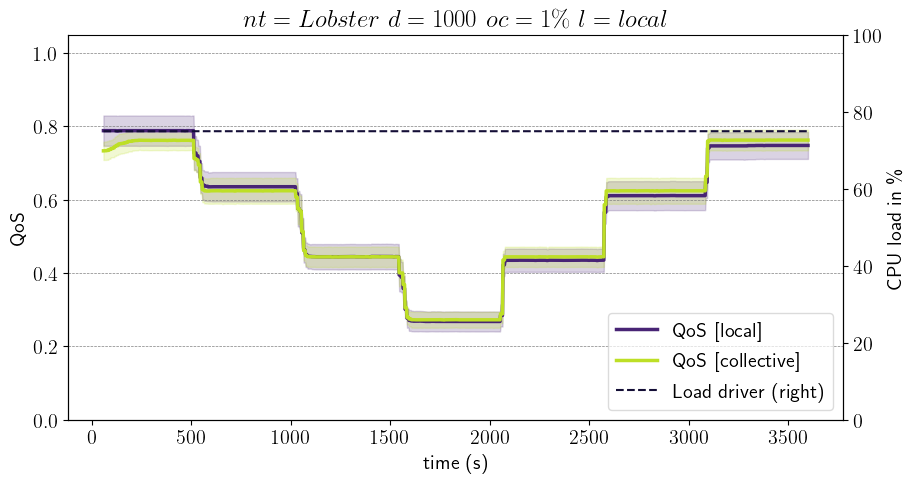

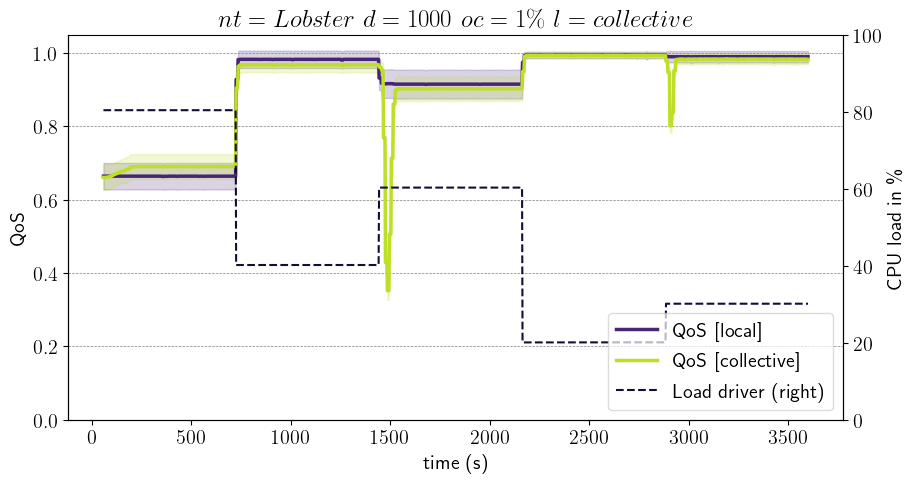

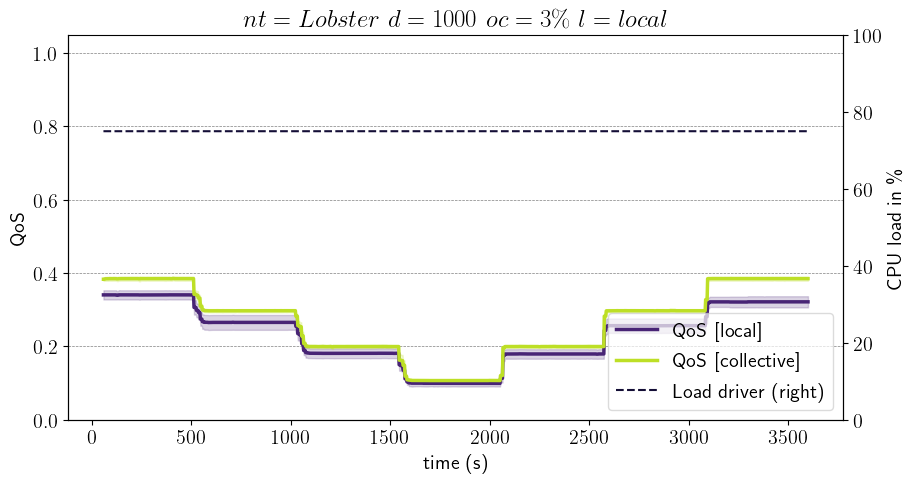

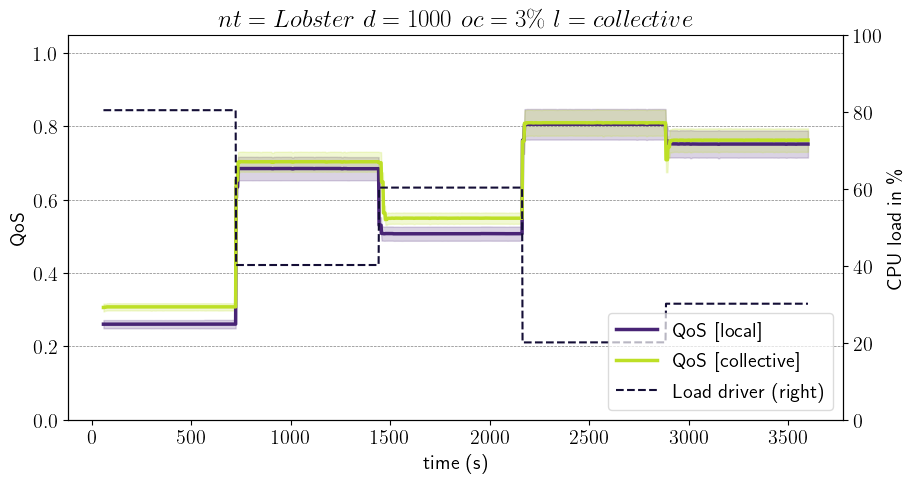

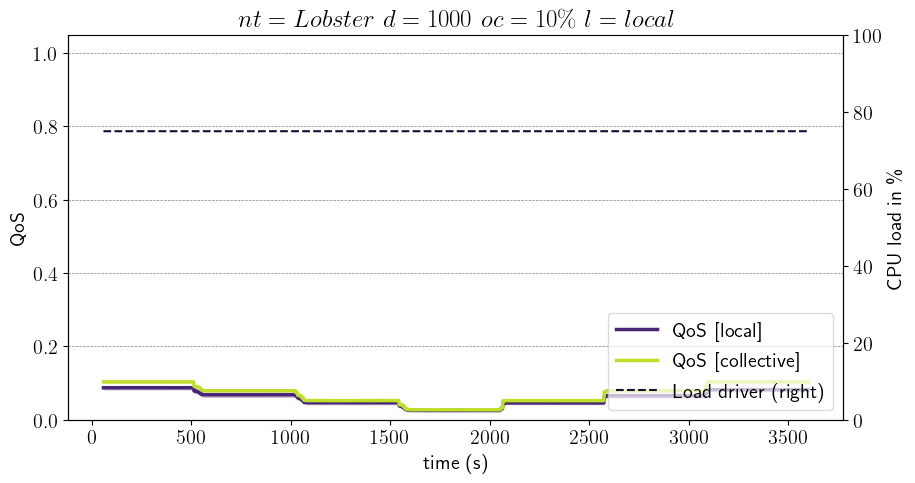

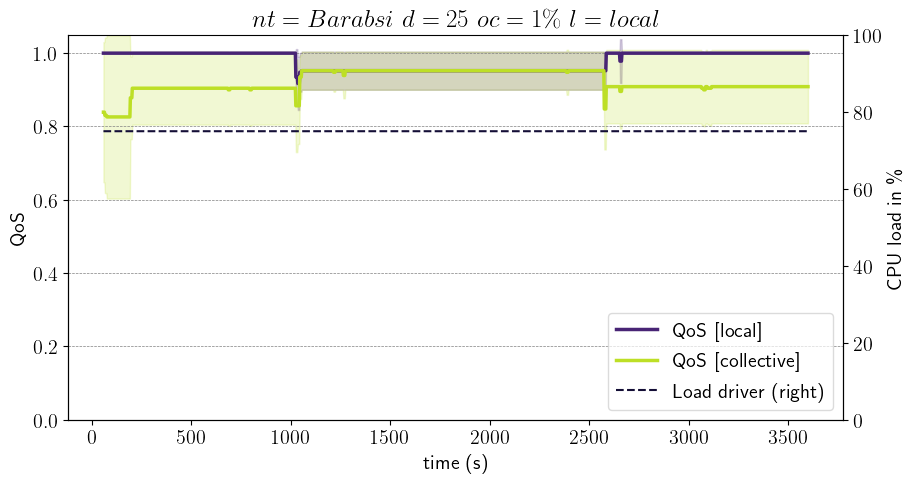

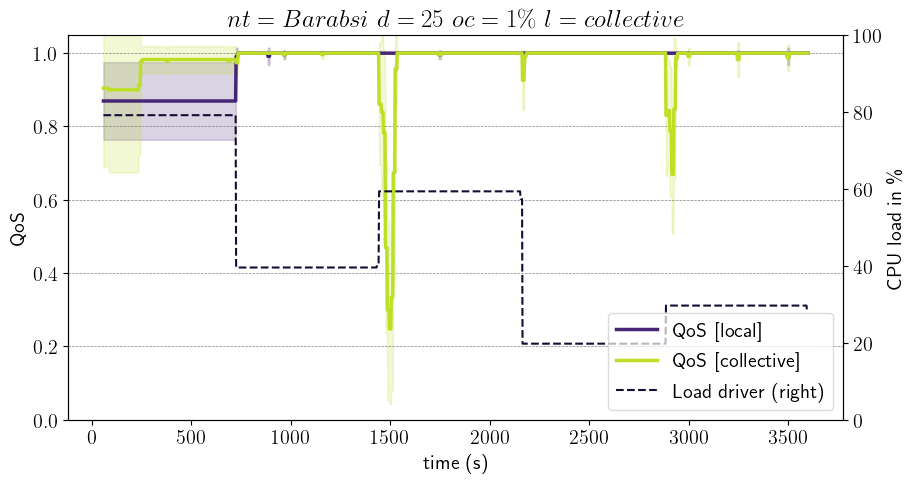

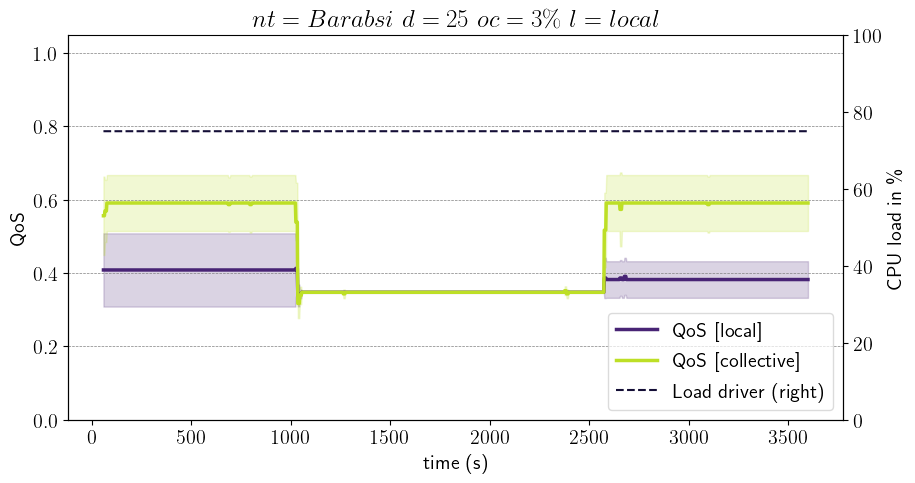

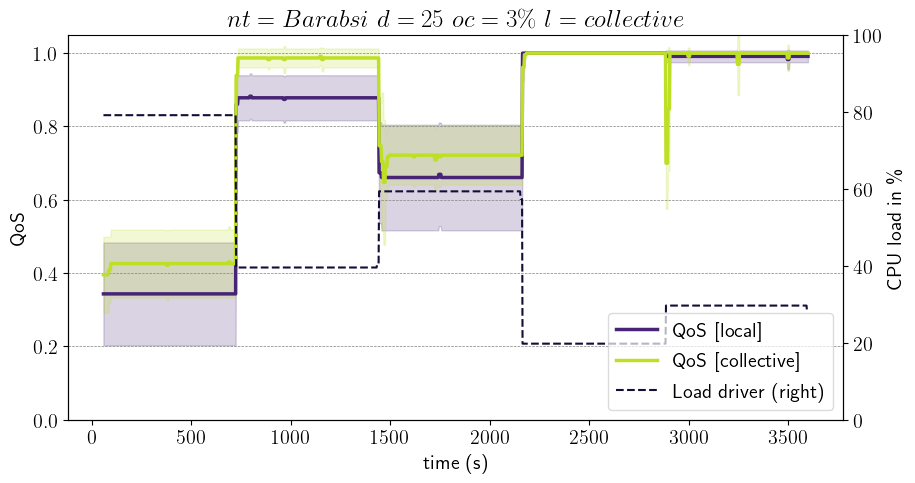

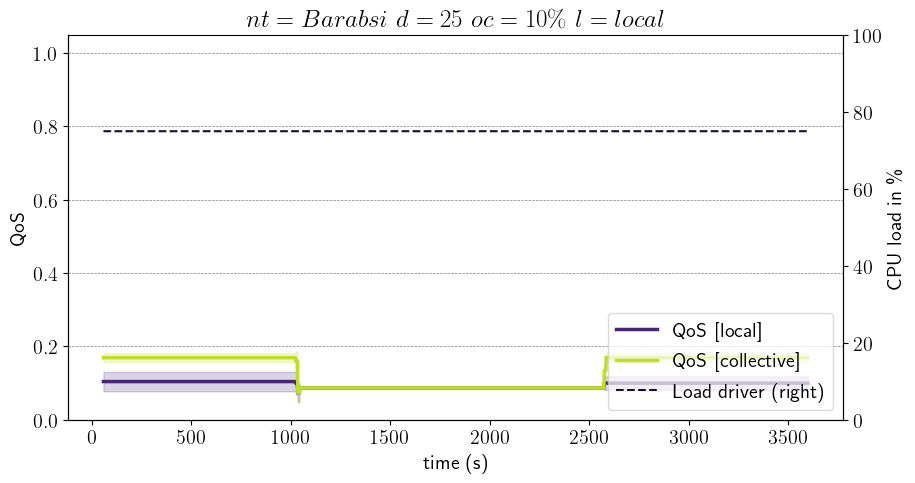

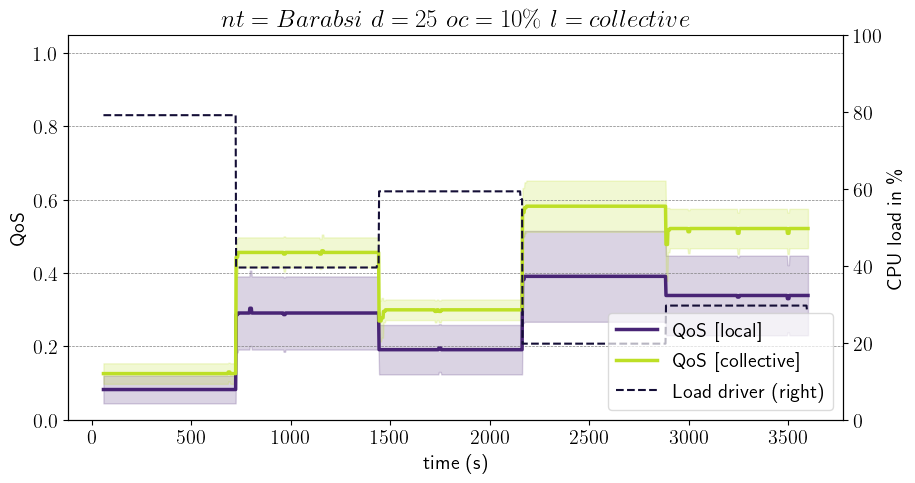

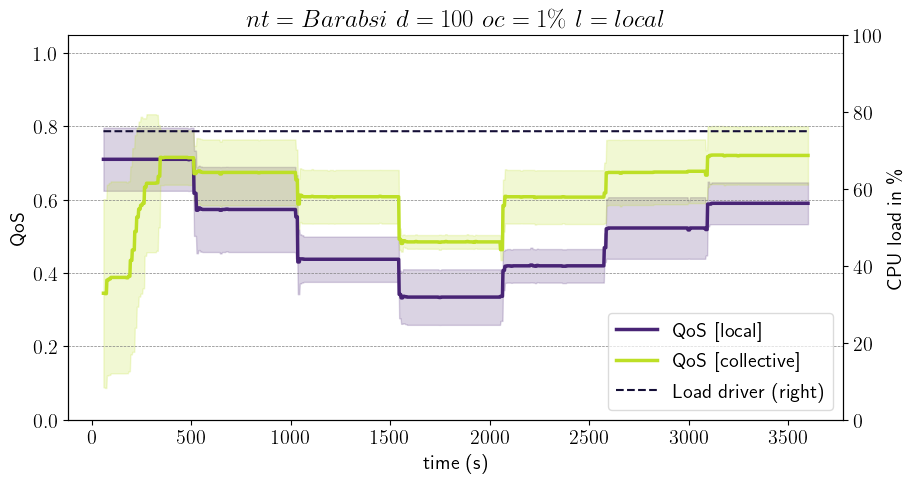

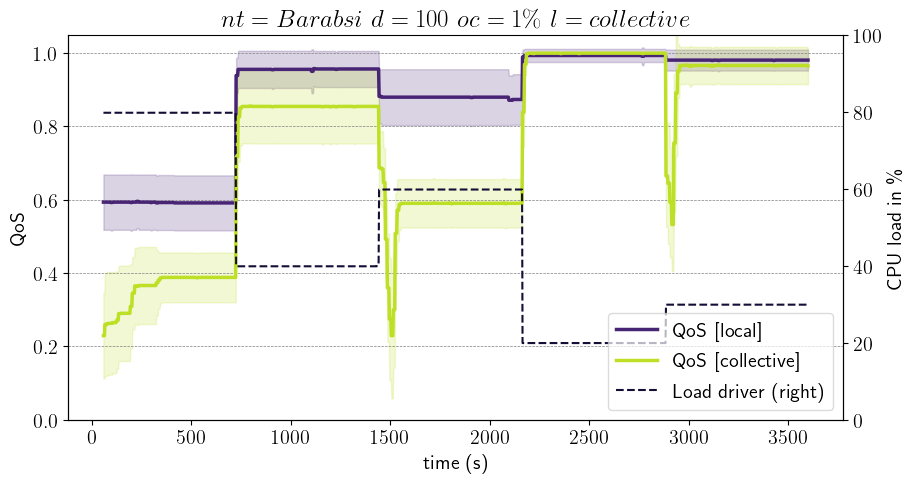

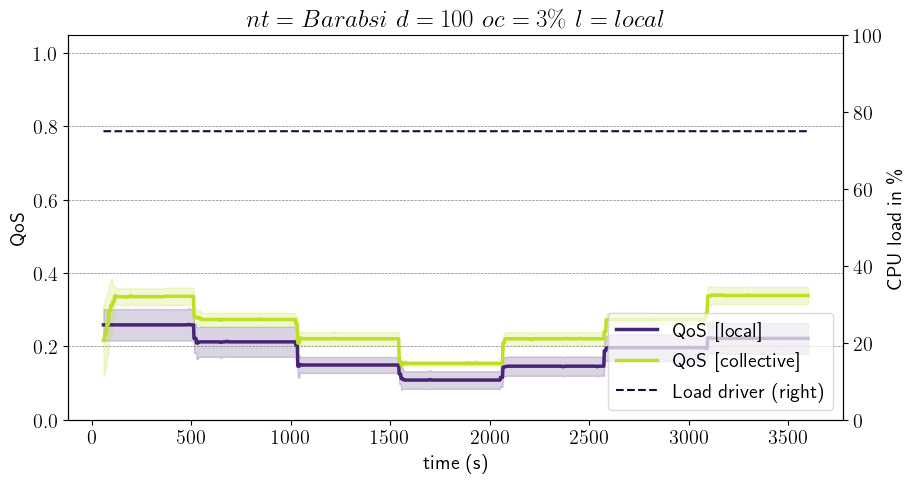

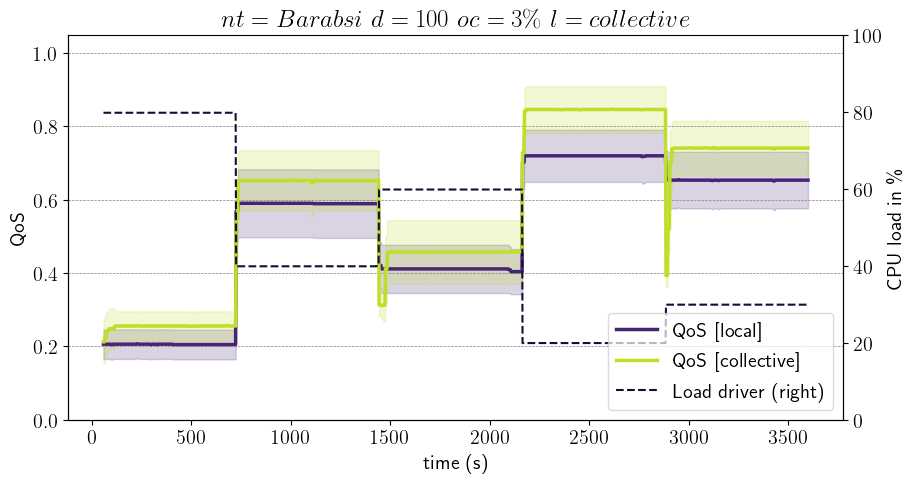

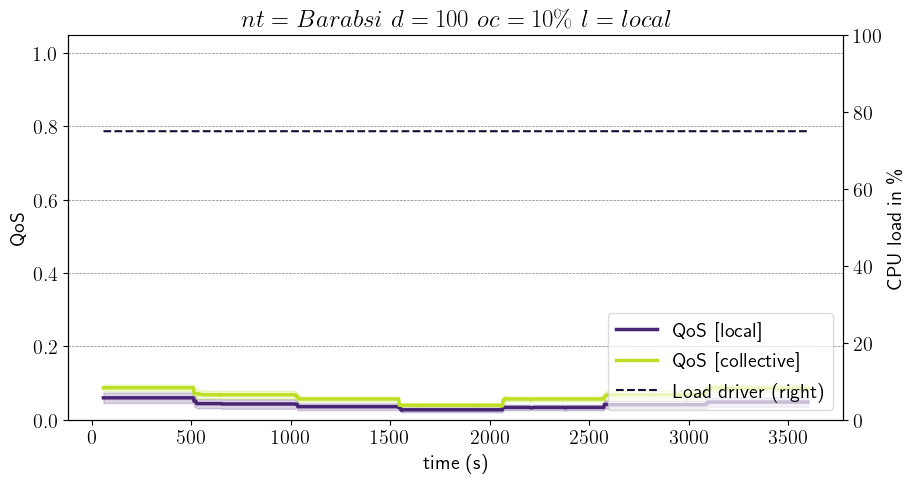

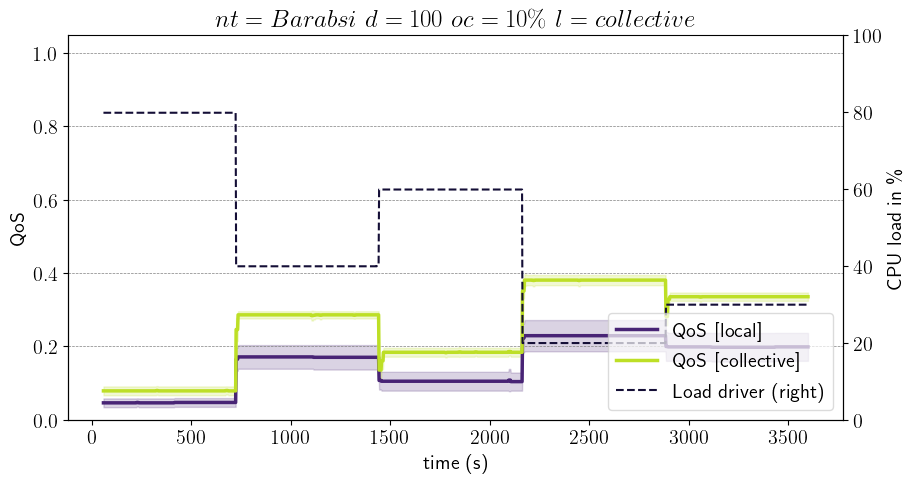

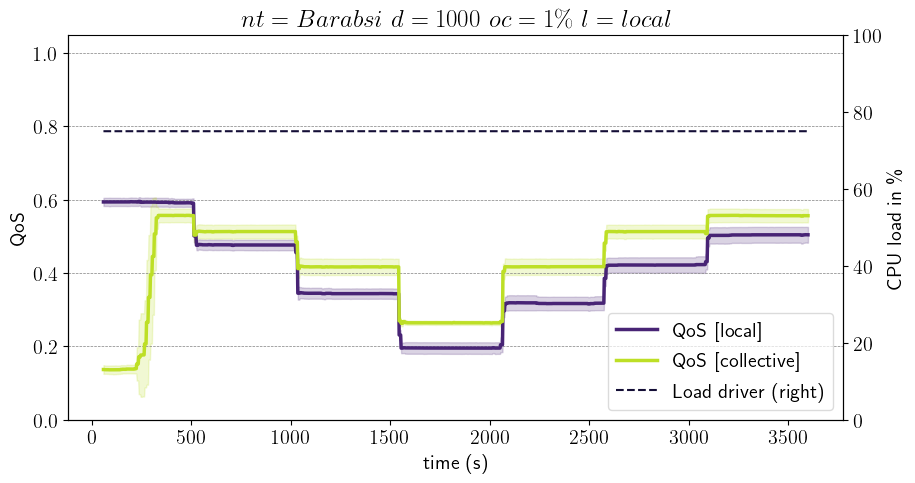

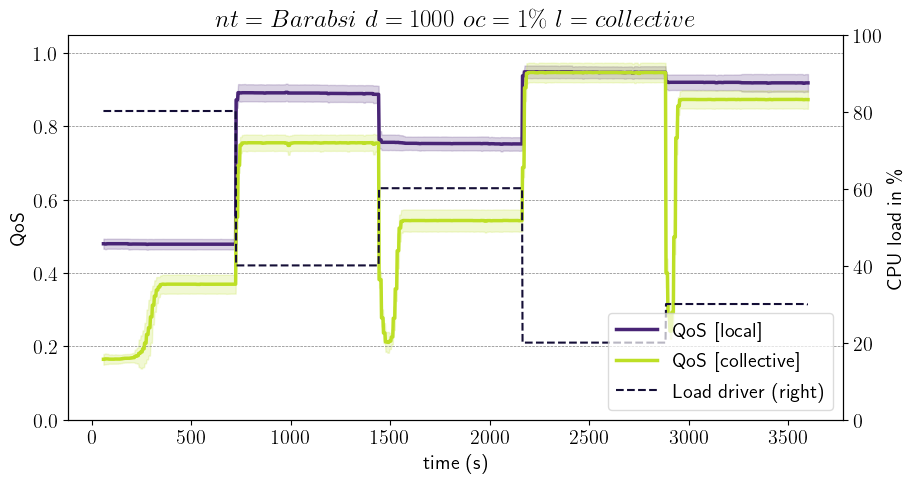

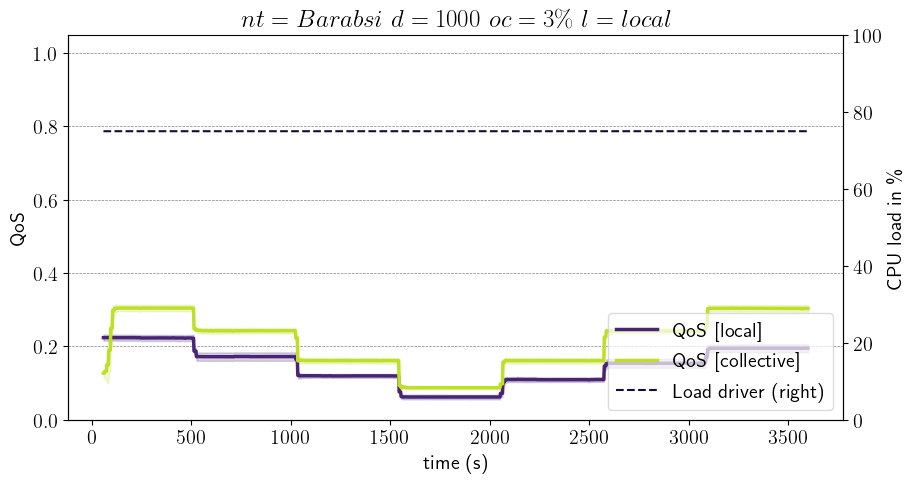

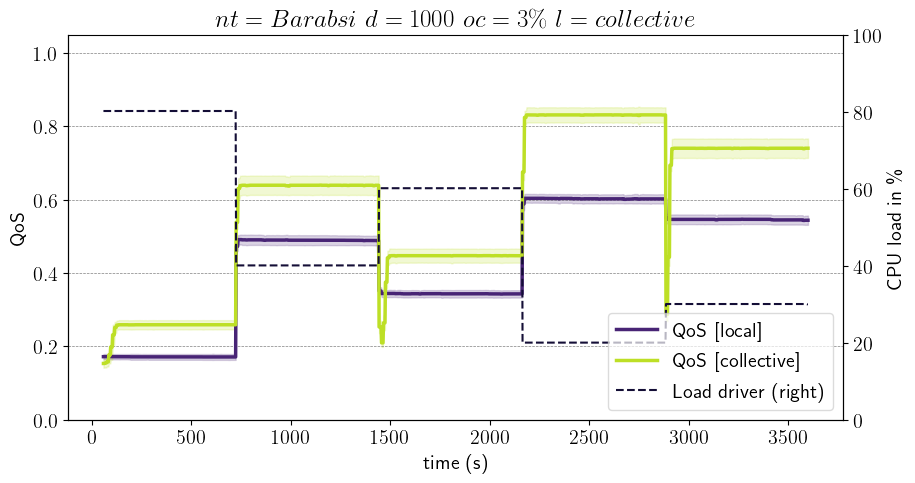

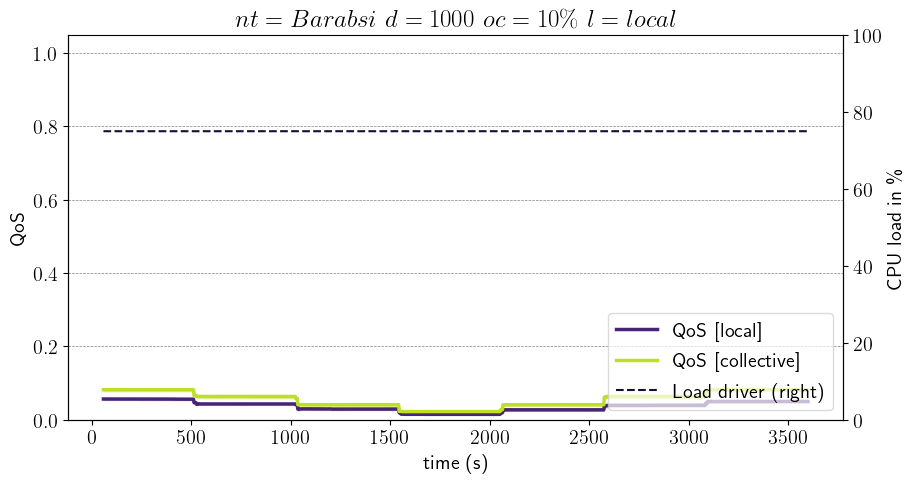

In [23]:
x_time = lobster['time'].to_numpy()

behavior = dataset.coords["behavior"].values
devices = dataset.coords["devices"].values
computationalCost = dataset.coords["computationalCost"].values
load = dataset.coords["load"].values

import matplotlib.cm as cmx

colorscale_margin = 0.1

matplotlib.rcParams.update({
    'font.size': 14.5,
    "text.usetex": True,
})

def lammerda(colormap, x):
    return colormap(x*(1-colorscale_margin * 2) + colorscale_margin)

def print_charts(dataset, stdev, time, net):
    for dev in devices:
        for compCost in computationalCost:
            for ld in load:
                (simple_values, simple_plus_errors, simple_minus_errors) = extract_values(dataset, stdev, "simple", compCost, dev, ld)
                (advanced_values, advanced_plus_errors, advanced_minus_errors) = extract_values(dataset, stdev, "advanced", compCost, dev, ld)
                load_driver = dataset.sel({"behavior": "simple", "computationalCost": compCost, "devices": dev, "load": ld }, drop=True)["load[mean]"].to_numpy()
                # effective_load = dataset.sel({"behavior": "simple", "computationalCost": compCost, "devices": dev, "load": ld }, drop=True)["effectiveLoad[mean]"].to_numpy()
                dataset_plot = pd.DataFrame({ "time": time, "QoS [static]": simple_values, "QoS [dynamic]": advanced_values, "Load driver": load_driver })
                dataset_plot = dataset_plot.rename(columns={"QoS [static]": "QoS [local]", "QoS [dynamic]": "QoS [collective]"})
                #fig, ax = plt.subplots(figsize=(8,4))
                
                ax = dataset_plot.plot(x="time", y=["QoS [local]", "QoS [collective]"], ylabel="QoS", figsize=(10, 5), ylim=(0, 1.05), colormap=lambda x: lammerda(cmx.viridis, x), linewidth=2.5, legend=False)
                ax2 = dataset_plot.plot(x="time", y=["Load driver"], ylabel=r"CPU load in \%", xlabel="time (s)", secondary_y = True, ax=ax, linestyle="dashed", ylim=(0, 100.05), colormap=lambda x: lammerda(cmx.magma, x), linewidth=1.5, legend=False)
    
                ax.set_title(r"$nt={0}$ $d={1}$ $oc={2}\%$ $l={3}$".format("Barabsi" if net.find("barabasi") == 0 else "Lobster", int(dev), int(compCost), "local" if ld == 0 else "collective"), fontsize=18)
                ax.fill_between(time, simple_plus_errors, simple_minus_errors, alpha=0.2, color=lammerda(cmx.viridis, 0))
                ax.fill_between(time, advanced_plus_errors, advanced_minus_errors, alpha=0.2, color=lammerda(cmx.viridis, 1))
                ax.set_facecolor("white")
                ax.get_xaxis().set_visible(True)
                ax.grid(axis = 'y', color = 'gray', linestyle = '--', linewidth = 0.5)
                ax.spines['top'].set_visible(False)

                lines, labels = ax.get_legend_handles_labels()
                lines2, labels2 = ax2.get_legend_handles_labels()
                plt.legend(lines + lines2, labels + labels2, framealpha=0.7, loc=4)

                figure = ax.get_figure()
                figure.savefig("./charts/{0}-{1}-{2}-{3}.svg".format(net, int(dev), int(compCost), "local" if ld == 0.0 else "collective"))

    matplotlib.pyplot.close()

print_charts(lobster, lobster_stdevs, x_time, "lobster-1h")
print_charts(barabasi, barabasi_stdevs, x_time, "barabasi-1h")

In [24]:
# CONFIGURE SCRIPT
# Where to find Alchemist data files
directory = '../data/720'
# Where to save charts
output_directory = '../charts/custom-charts'
# How to name the summary of the processed data
pickleOutput = 'data_summary'
# Experiment prefixes: one per experiment (root of the file name)
experiments = ['load_based']
floatPrecision = '{: 0.3f}'
# Number of time samples 
timeSamples = 360
# time management
minTime = 60
maxTime = 720
timeColumnName = 'time'
logarithmicTime = False
excludeVariables = []
# One or more variables are considered random and "flattened"
seedVars = ['random']
# Label mapping

In [25]:
timefun = np.logspace if logarithmicTime else np.linspace
means = {}
stdevs = {}
for experiment in experiments:
    # Collect all files for the experiment of interest
    import fnmatch
    allfiles = filter(lambda file: fnmatch.fnmatch(file, experiment + '_*.csv'), os.listdir(directory))
    allfiles = [directory + '/' + name for name in allfiles]
    allfiles.sort()
    # From the file name, extract the independent variables
    dimensions = {}
    for file in allfiles:
        dimensions = mergeDicts(dimensions, extractCoordinates(file, excludeVariables))
    dimensions = {k: sorted(v) for k, v in dimensions.items()}
    # Add time to the independent variables
    dimensions[timeColumnName] = range(0, timeSamples)
    print(dimensions)
    # Compute the matrix shape
    shape = tuple(len(v) for k, v in dimensions.items())
    # Prepare the Dataset
    dataset = xr.Dataset()
    for k, v in dimensions.items():
        dataset.coords[k] = v
    if len(allfiles) == 0:
        print("WARNING: No data for experiment " + experiment)
        means[experiment] = dataset
        stdevs[experiment] = xr.Dataset()
    else:
        varNames = extractVariableNames(allfiles[0])
        for v in varNames:
            if v != timeColumnName:
                novals = np.ndarray(shape)
                novals.fill(float('nan'))
                dataset[v] = (dimensions.keys(), novals)
        # Compute maximum and minimum time, create the resample
        timeColumn = varNames.index(timeColumnName)
        allData = { file: np.matrix(openCsv(file)) for file in allfiles }
        computeMin = minTime is None
        computeMax = maxTime is None
        if computeMax:
            maxTime = float('-inf')
            for data in allData.values():
                maxTime = max(maxTime, data[-1, timeColumn])
        if computeMin:
            minTime = float('inf')
            for data in allData.values():
                minTime = min(minTime, data[0, timeColumn])
        timeline = timefun(minTime, maxTime, timeSamples)
        # Resample
        for file in allData:
#                    print(file)
            allData[file] = convert(timeColumn, timeline, allData[file])
        # Populate the dataset
        for file, data in allData.items():
            dataset[timeColumnName] = timeline
            for idx, v in enumerate(varNames):
                if v != timeColumnName:
                    darray = dataset[v]
                    experimentVars = extractCoordinates(file, excludeVariables)
                    darray.loc[experimentVars] = data[:, idx].A1
        # Fold the dataset along the seed variables, producing the mean and stdev datasets
        mergingVariables = [seed for seed in seedVars if seed in dataset.coords]
        means[experiment] = dataset.mean(dim = mergingVariables, skipna=True)
        stdevs[experiment] = dataset.std(dim = mergingVariables, skipna=True)



{'computationalCost': [1.0, 3.0, 10.0], 'simulationSeconds': [720.0], 'load': [0.0, 1.0], 'random': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0], 'behavior': ['advanced', 'simple'], 'devices': [25.0, 100.0, 1000.0], 'network': ['barabasi', 'lobster'], 'time': range(0, 360)}


# QoS Analysis for load balancing scenario

## Lobster network

In [26]:
dataset = means['load_based']
stdevs = stdevs['load_based']
dataset

<xarray.Dataset> Size: 2MB
Dimensions:              (computationalCost: 3, simulationSeconds: 1, load: 2,
                          behavior: 2, devices: 3, network: 2, time: 360)
Coordinates:
  * computationalCost    (computationalCost) float64 24B 1.0 3.0 10.0
  * simulationSeconds    (simulationSeconds) float64 8B 720.0
  * load                 (load) float64 16B 0.0 1.0
  * behavior             (behavior) <U8 64B 'advanced' 'simple'
  * devices              (devices) float64 24B 25.0 100.0 1e+03
  * network              (network) <U8 64B 'barabasi' 'lobster'
  * time                 (time) float64 3kB 60.0 61.84 63.68 ... 718.2 720.0
Data variables:
    canOffload[sum]      (computationalCost, simulationSeconds, load, behavior, devices, network, time) float64 207kB ...
    wantToOffload[sum]   (computationalCost, simulationSeconds, load, behavior, devices, network, time) float64 207kB ...
    qos                  (computationalCost, simulationSeconds, load, behavior, devices, network, time) float64 207kB ...
    effectiveLoad[mean]  (computationalCost, simulationSeconds, load, behavior, devices, network, time) float64 207kB ...
    effectiveLoad[max]   (computationalCost, simulationSeconds, load, behavior, devices, network, time) float64 207kB ...
    effectiveLoad[min]   (computationalCost, simulationSeconds, load, behavior, devices, network, time) float64 207kB ...
    load[mean]           (computationalCost, simulationSeconds, load, behavior, devices, network, time) float64 207kB ...
    latency[mean]        (computationalCost, simulationSeconds, load, behavior, devices, network, time) float64 207kB ...
    latency[max]         (computationalCost, simulationSeconds, load, behavior, devices, network, time) float64 207kB ...
    latency[min]         (computationalCost, simulationSeconds, load, behavior, devices, network, time) float64 207kB ...

In [27]:
lobster_short = dataset.sel({"network": "lobster", "simulationSeconds": 720.0 }, drop=True)
lobster_short_stdevs = stdevs.sel({"network": "lobster", "simulationSeconds": 720.0 }, drop=True)

barabasi_short = dataset.sel({"network": "barabasi", "simulationSeconds": 720.0 }, drop=True)
barabasi_short_stdevs = stdevs.sel({"network": "barabasi", "simulationSeconds": 720.0 }, drop=True)
lobster_short

<xarray.Dataset> Size: 1MB
Dimensions:              (computationalCost: 3, load: 2, behavior: 2,
                          devices: 3, time: 360)
Coordinates:
  * computationalCost    (computationalCost) float64 24B 1.0 3.0 10.0
  * load                 (load) float64 16B 0.0 1.0
  * behavior             (behavior) <U8 64B 'advanced' 'simple'
  * devices              (devices) float64 24B 25.0 100.0 1e+03
  * time                 (time) float64 3kB 60.0 61.84 63.68 ... 718.2 720.0
Data variables:
    canOffload[sum]      (computationalCost, load, behavior, devices, time) float64 104kB ...
    wantToOffload[sum]   (computationalCost, load, behavior, devices, time) float64 104kB ...
    qos                  (computationalCost, load, behavior, devices, time) float64 104kB ...
    effectiveLoad[mean]  (computationalCost, load, behavior, devices, time) float64 104kB ...
    effectiveLoad[max]   (computationalCost, load, behavior, devices, time) float64 104kB ...
    effectiveLoad[min]   (computationalCost, load, behavior, devices, time) float64 104kB ...
    load[mean]           (computationalCost, load, behavior, devices, time) float64 104kB ...
    latency[mean]        (computationalCost, load, behavior, devices, time) float64 104kB ...
    latency[max]         (computationalCost, load, behavior, devices, time) float64 104kB ...
    latency[min]         (computationalCost, load, behavior, devices, time) float64 104kB ...

/home/nicolas/Documents/repos/reconfiguration-experiments/data-visualization/env/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


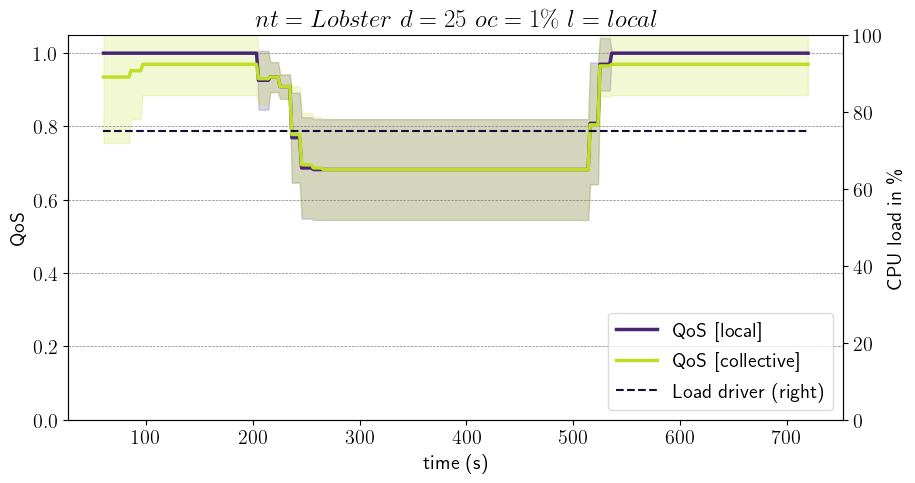

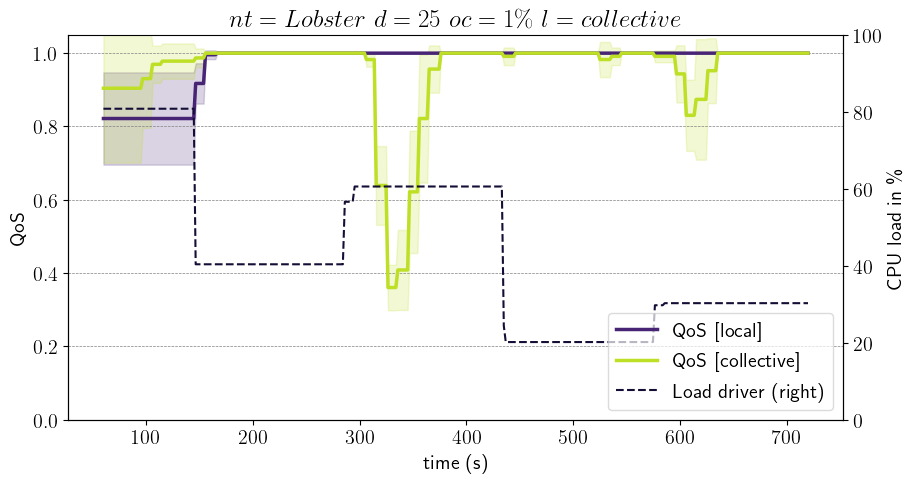

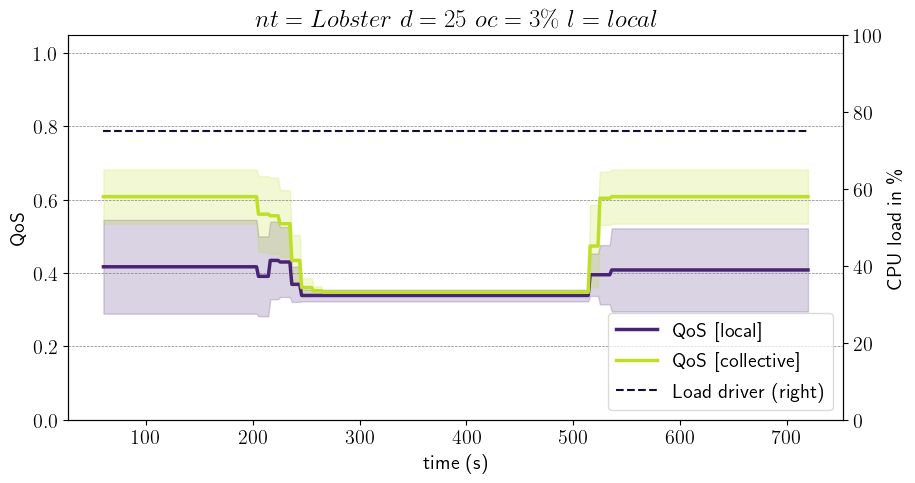

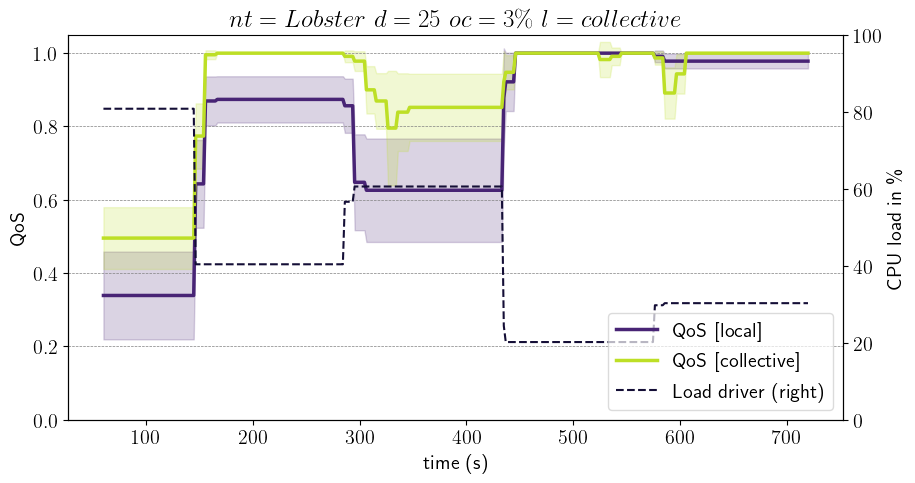

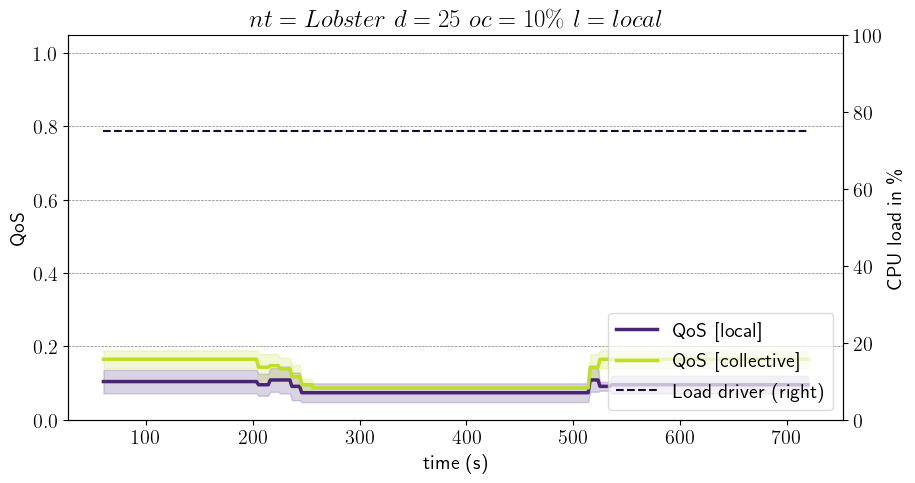

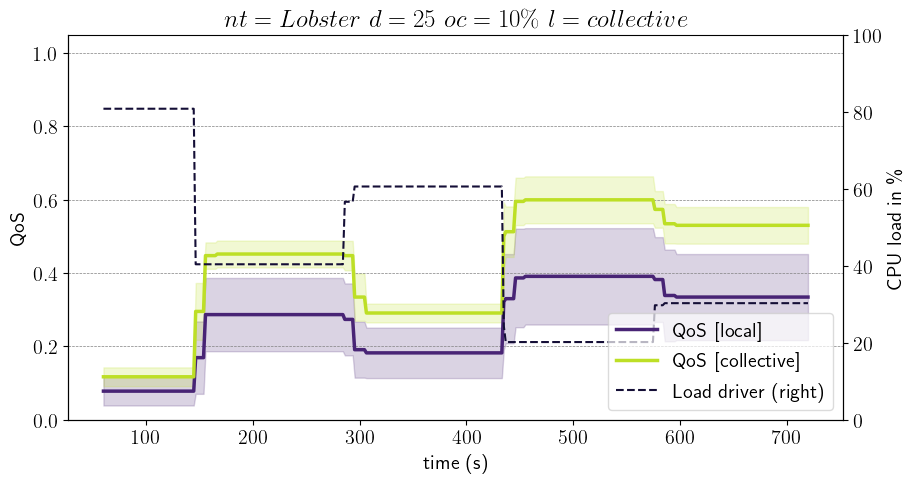

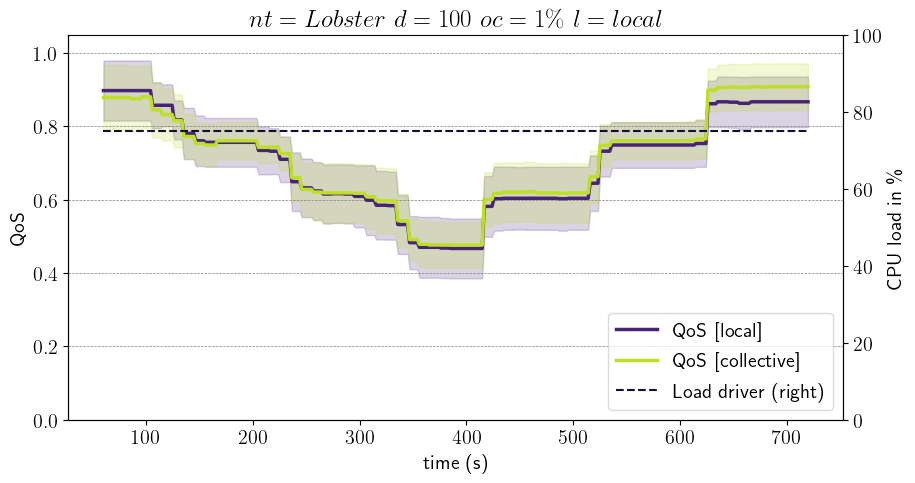

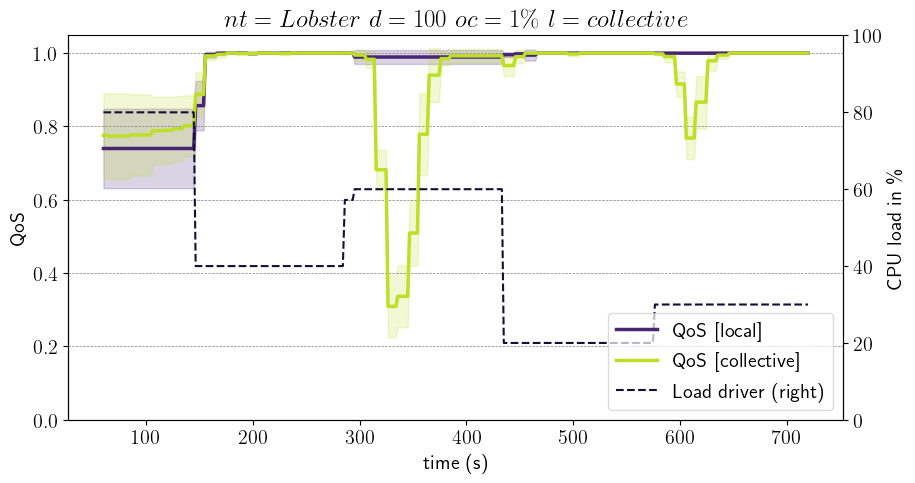

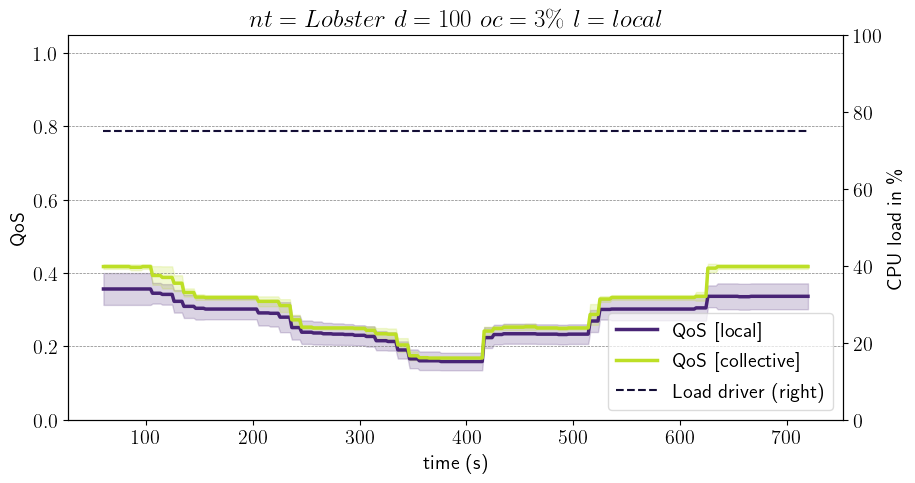

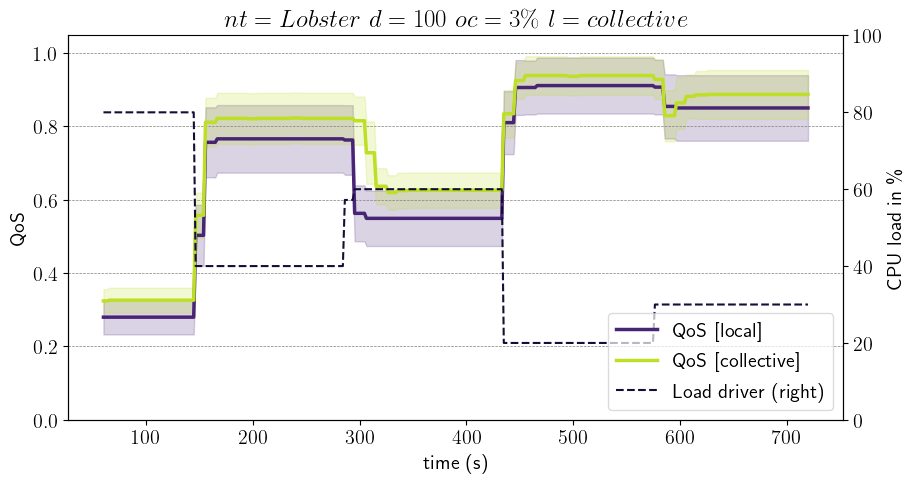

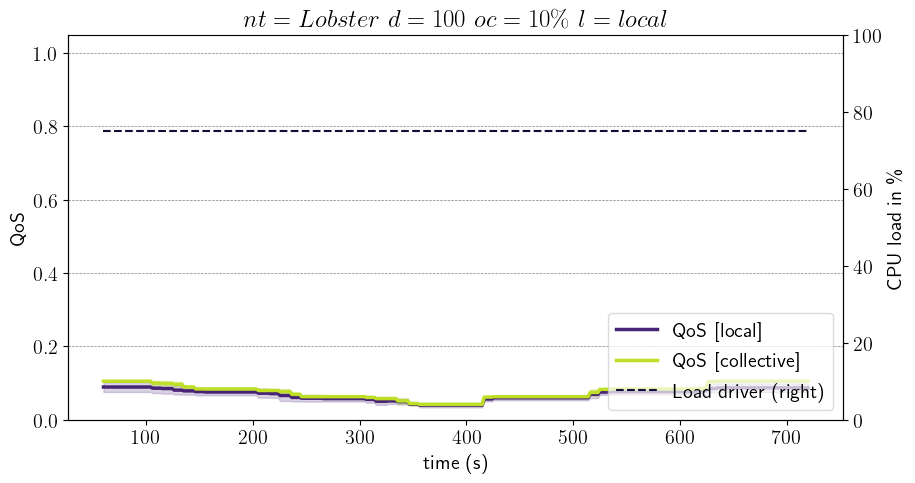

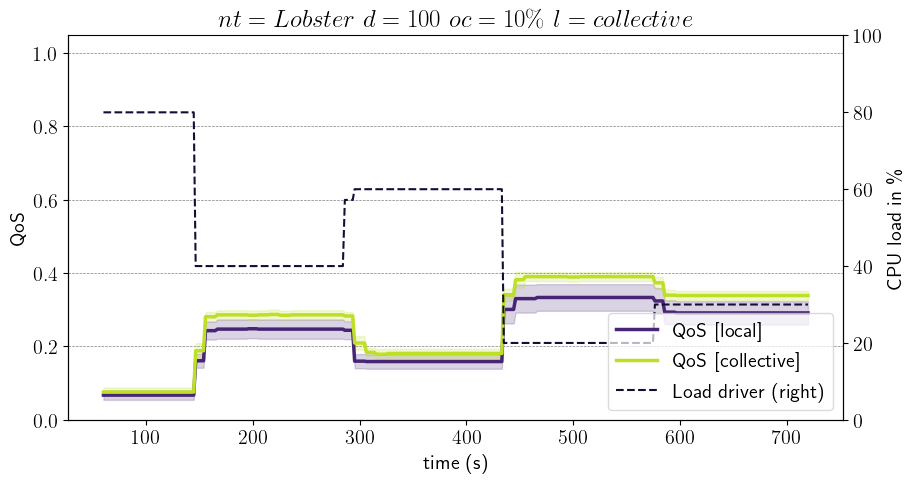

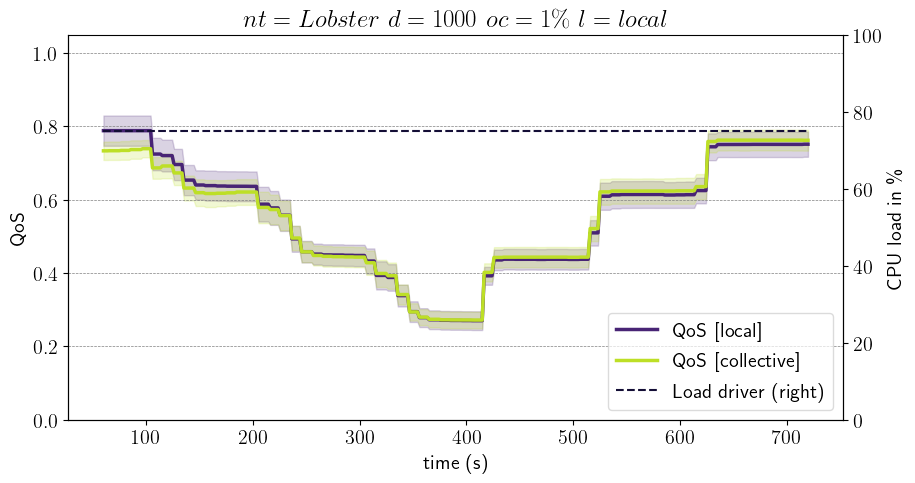

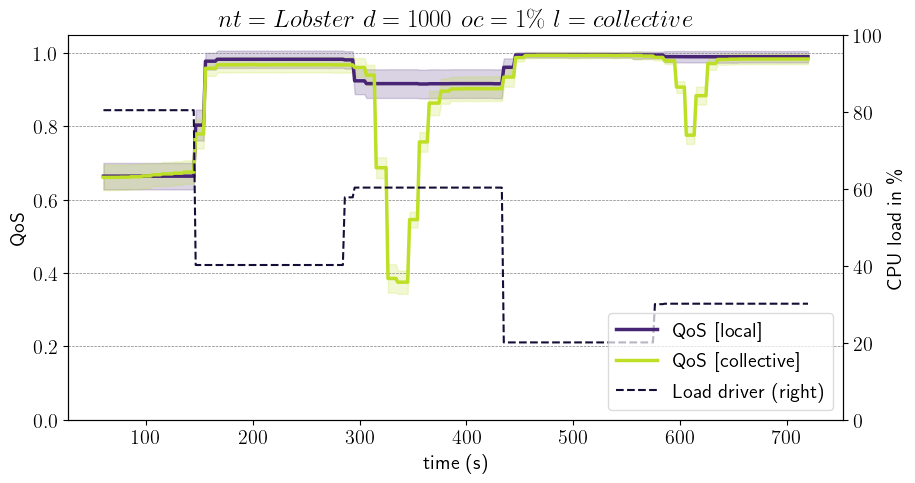

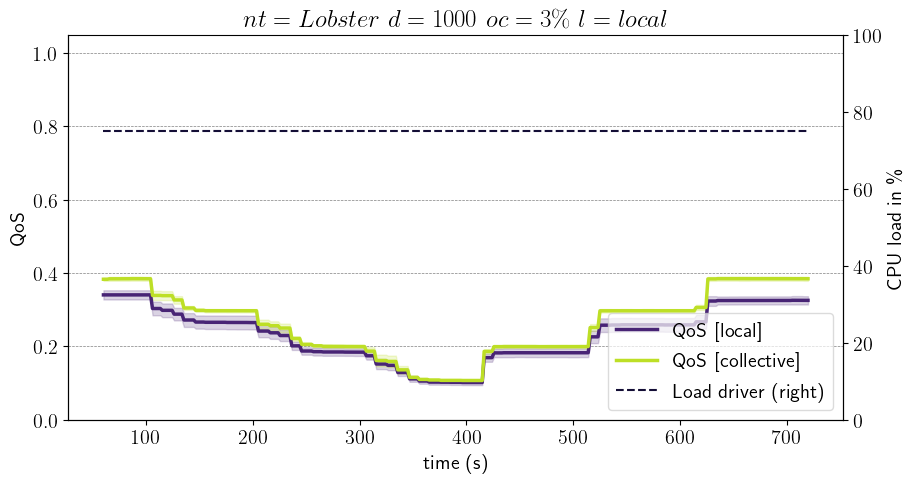

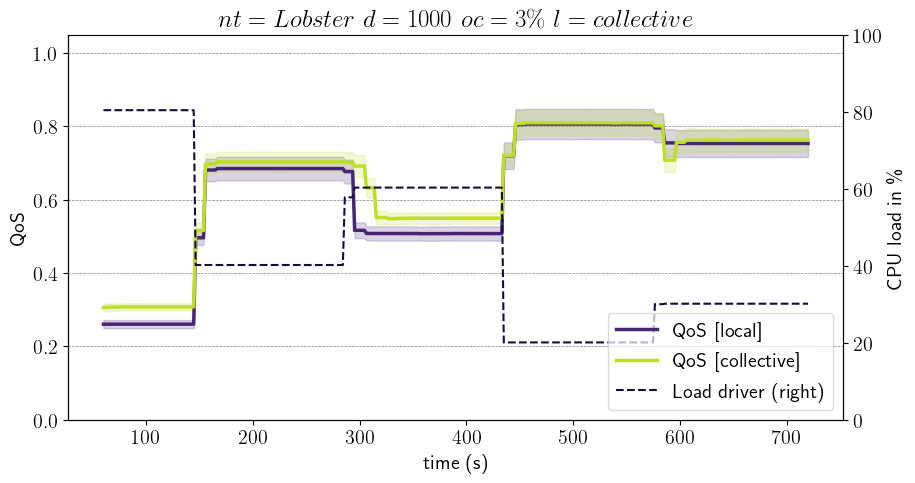

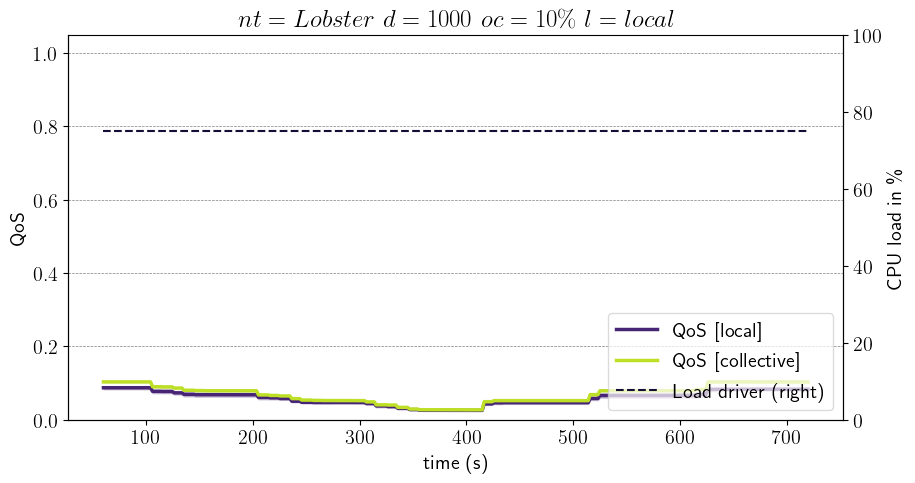

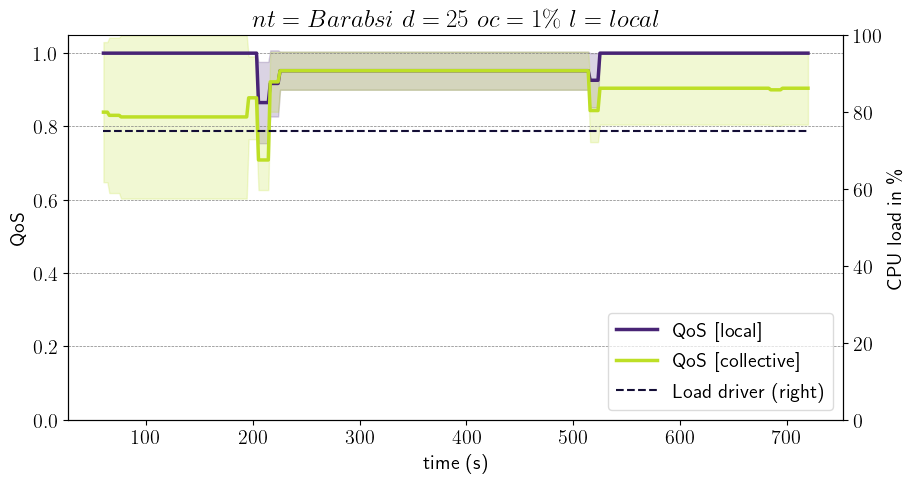

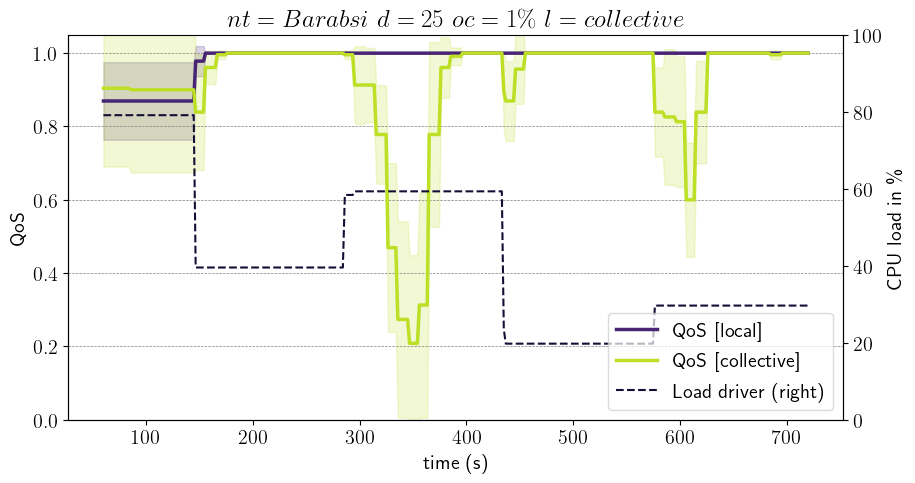

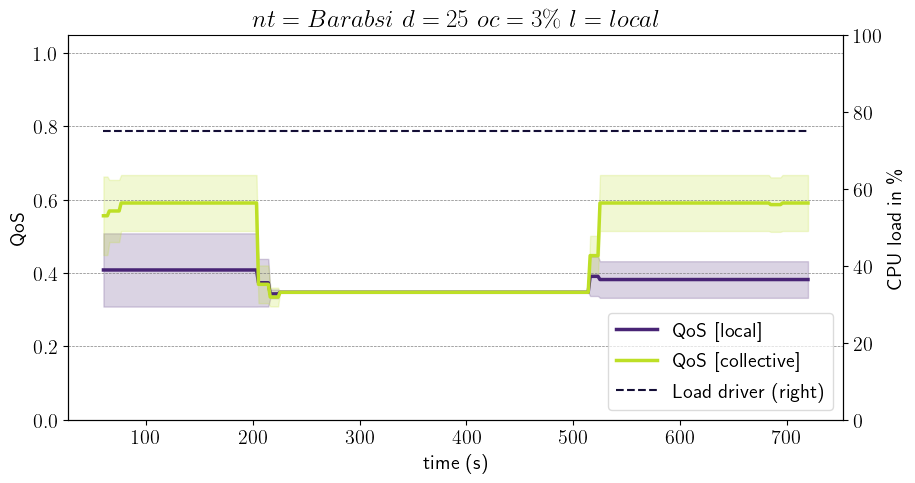

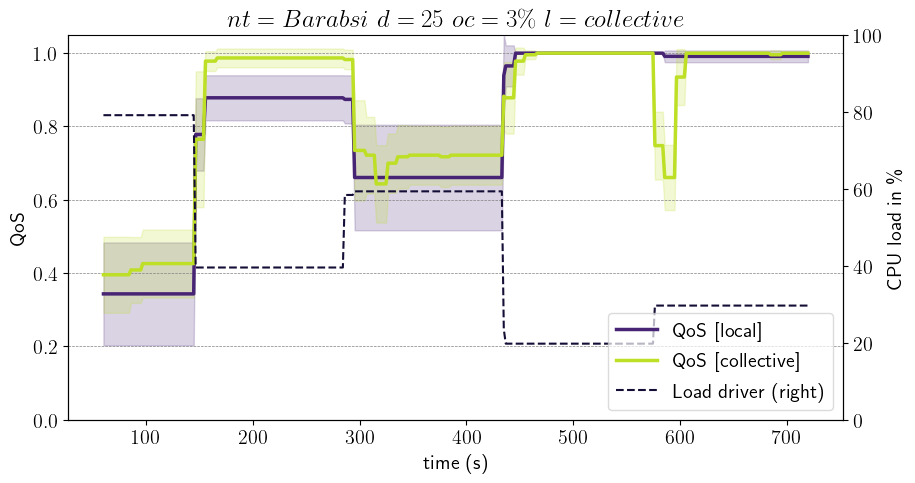

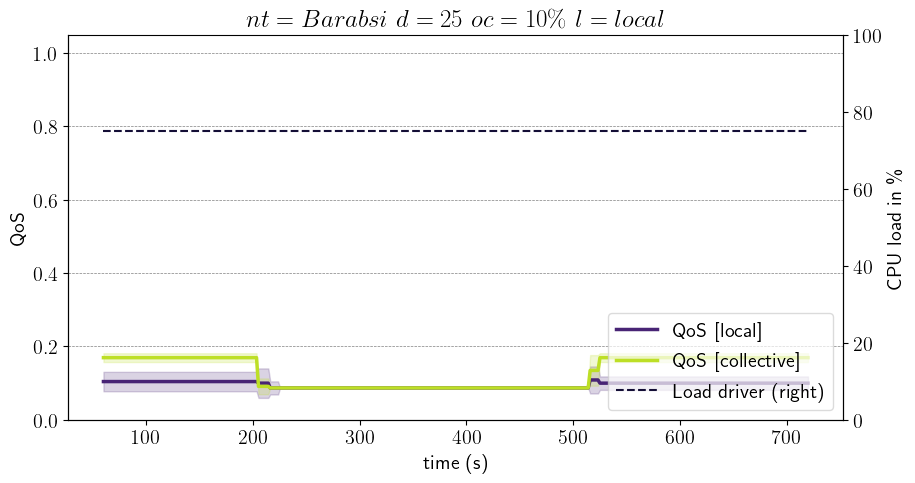

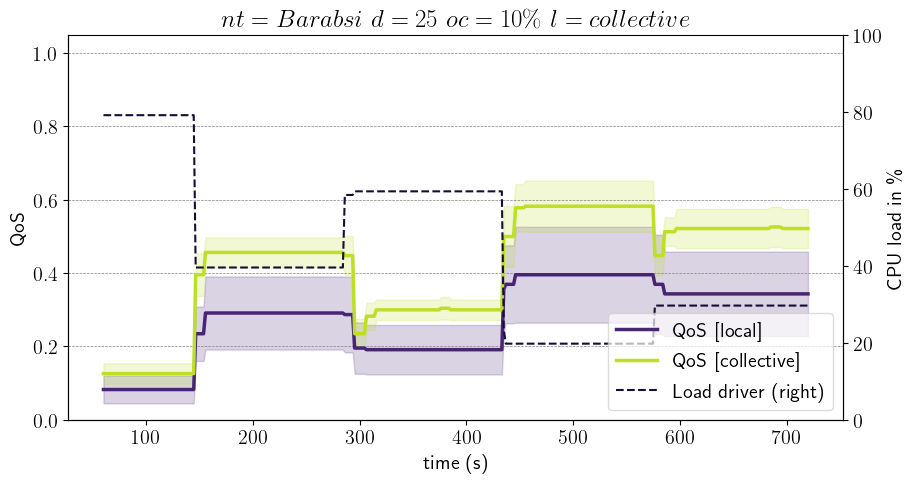

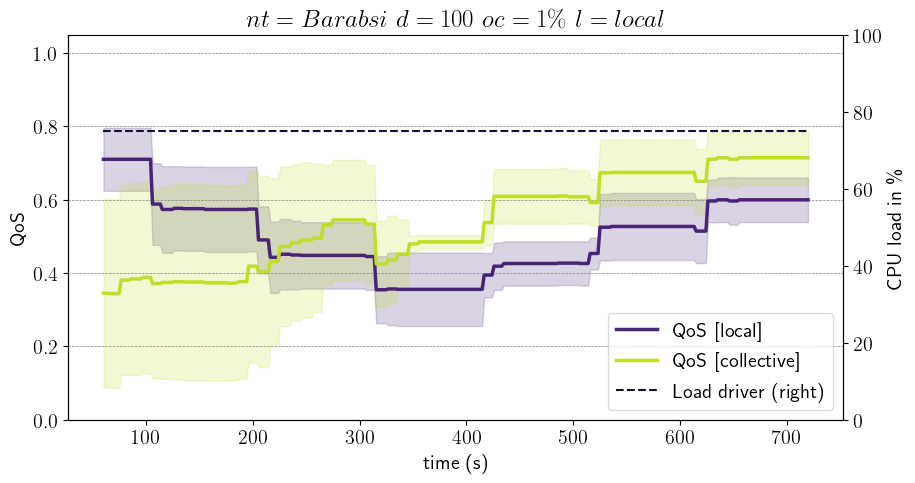

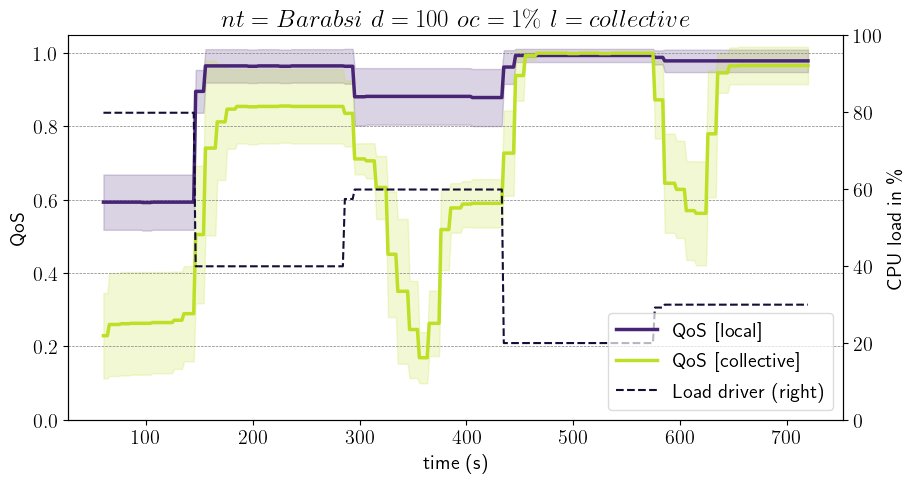

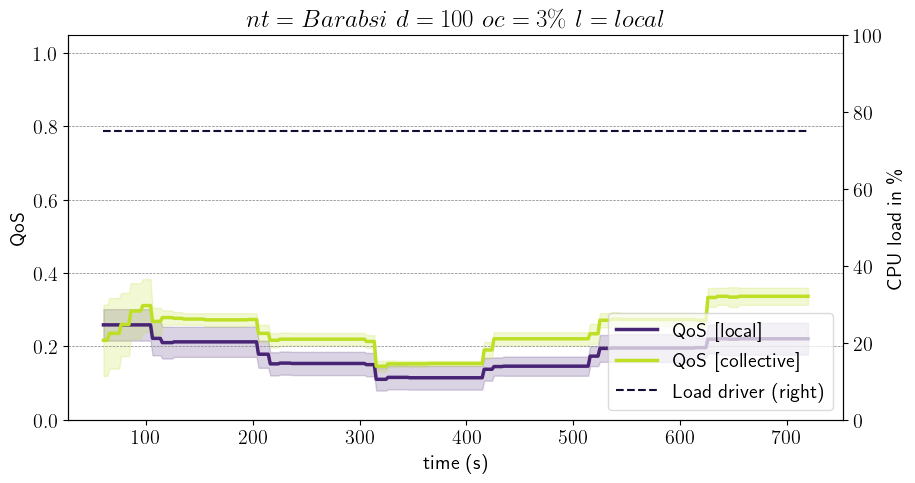

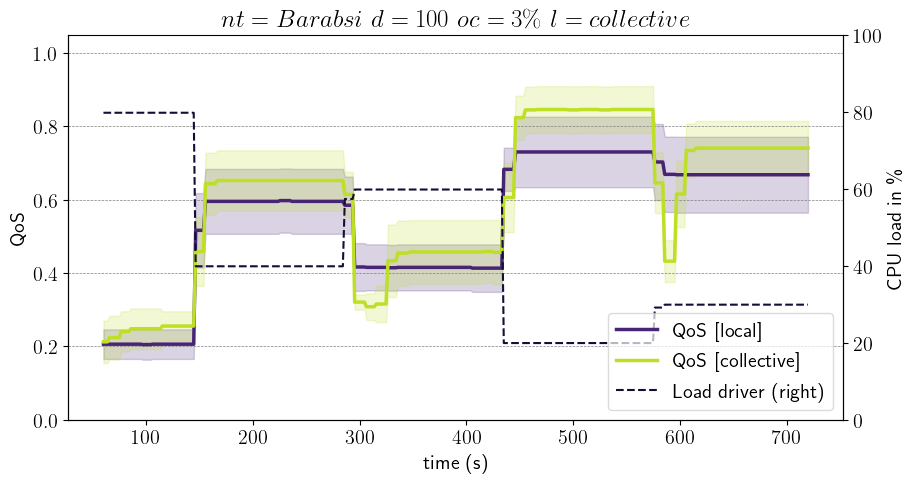

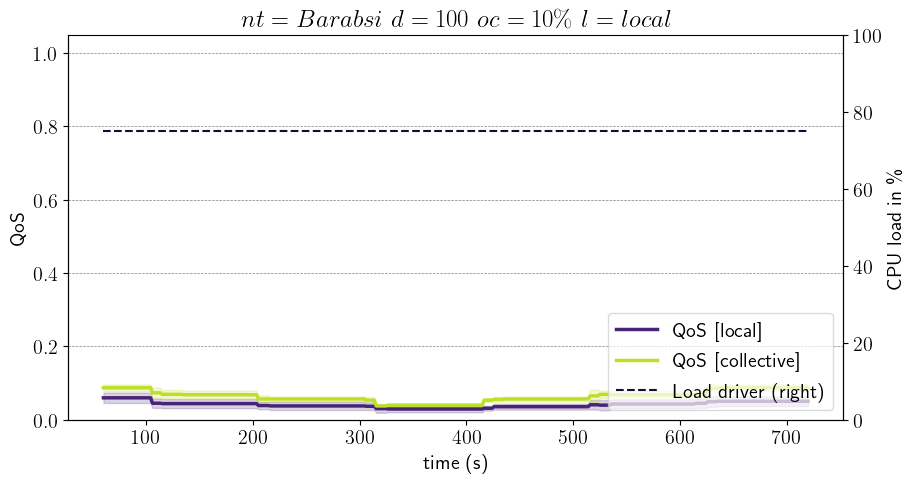

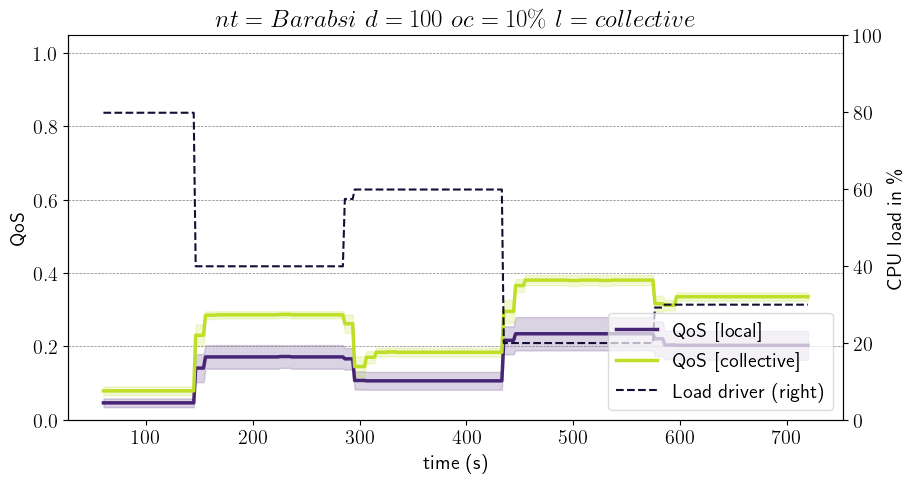

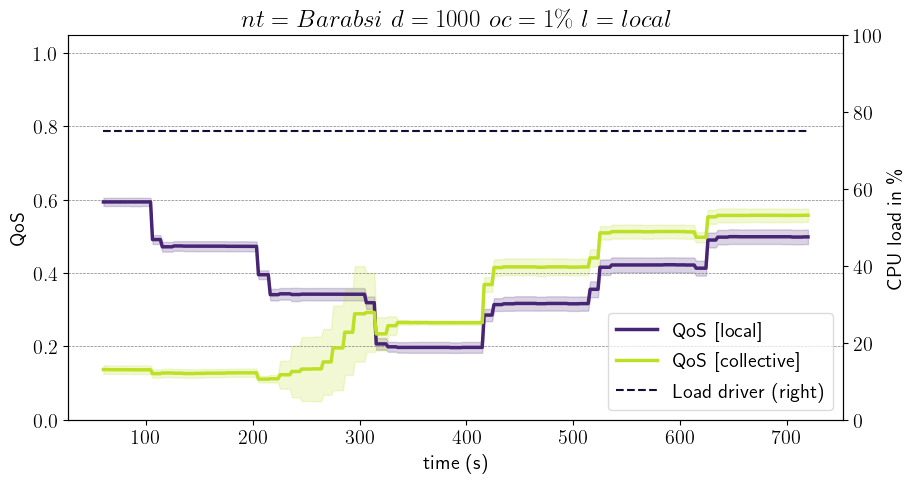

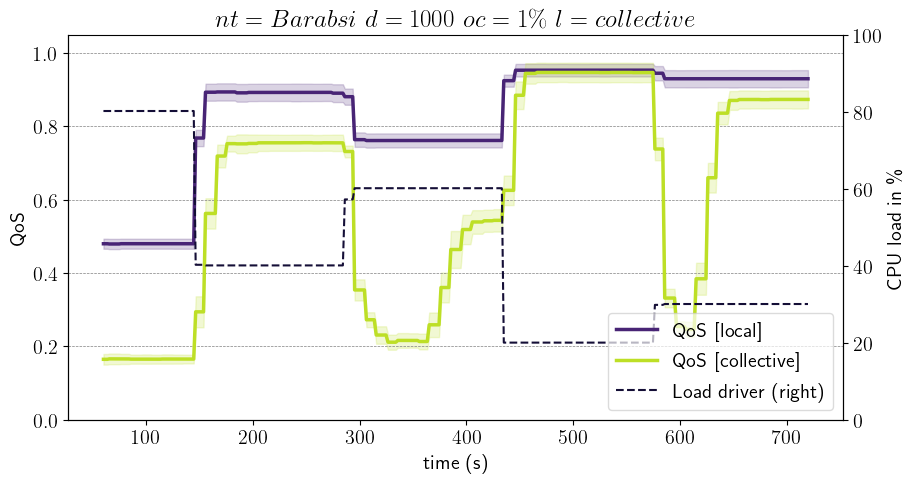

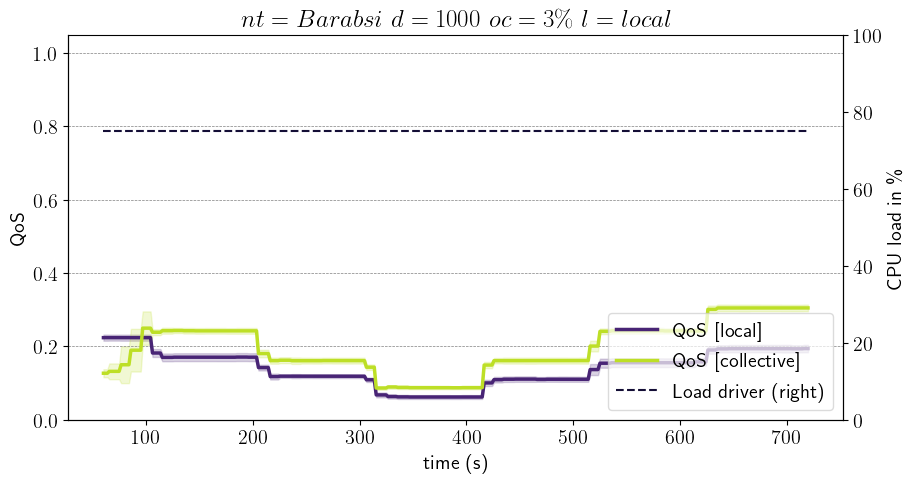

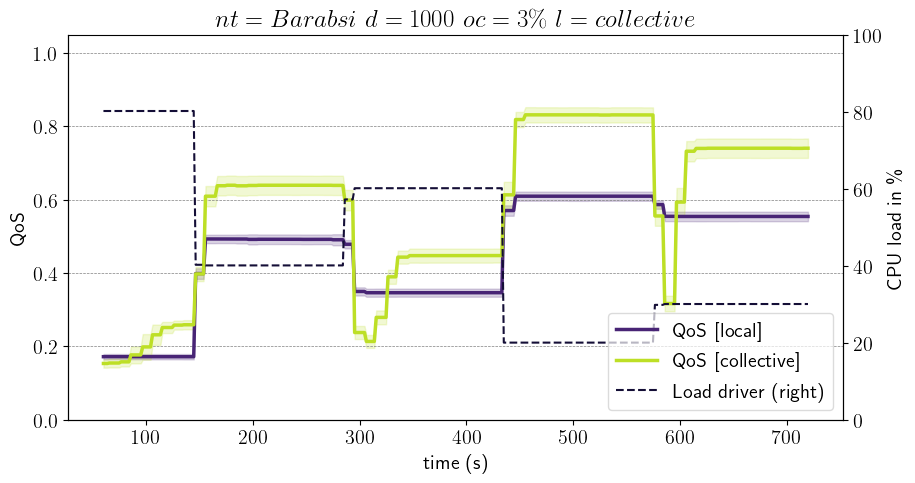

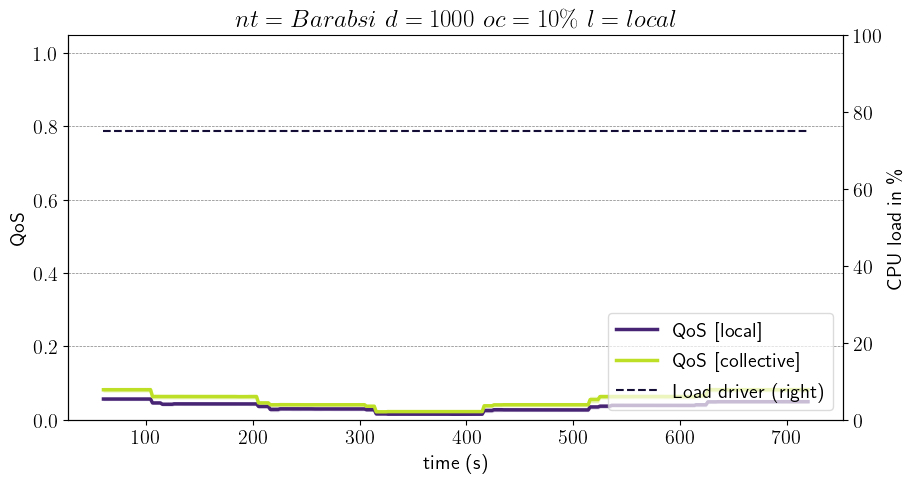

In [28]:
x_time = lobster_short['time'].to_numpy()

behavior = lobster_short.coords["behavior"].values
devices = lobster_short.coords["devices"].values
computationalCost = lobster_short.coords["computationalCost"].values
load = lobster_short.coords["load"].values

print_charts(lobster_short, lobster_short_stdevs, x_time, "lobster-10m")
print_charts(barabasi_short, barabasi_short_stdevs, x_time, "barabasi-10m")

In [29]:
time = lobster_short['time'].to_numpy()

(simple_values, simple_plus_errors_s1, simple_minus_errors_s1) = extract_values(barabasi_short, barabasi_short_stdevs, "simple", 3, 1000, 0)
(advanced_values, advanced_plus_errors_s1, advanced_minus_errors_s1) = extract_values(barabasi_short, barabasi_short_stdevs, "advanced", 3, 1000, 0)
load_driver = barabasi_short.sel({"behavior": "simple", "computationalCost": 3, "devices": 1000, "load": 0 }, drop=True)["load[mean]"].to_numpy()
# effective_load = barabasi_short.sel({"behavior": "simple", "computationalCost": 3, "devices": 1000, "load": 0 }, drop=True)["effectiveLoad[mean]"].to_numpy()
barabasi_costant = pd.DataFrame({ "time": time, "QoS [static]": simple_values, "QoS [dynamic]": advanced_values, "Load driver": load_driver })
barabasi_costant = barabasi_costant.rename(columns={"QoS [static]": "QoS [local]", "QoS [dynamic]": "QoS [collective]"})

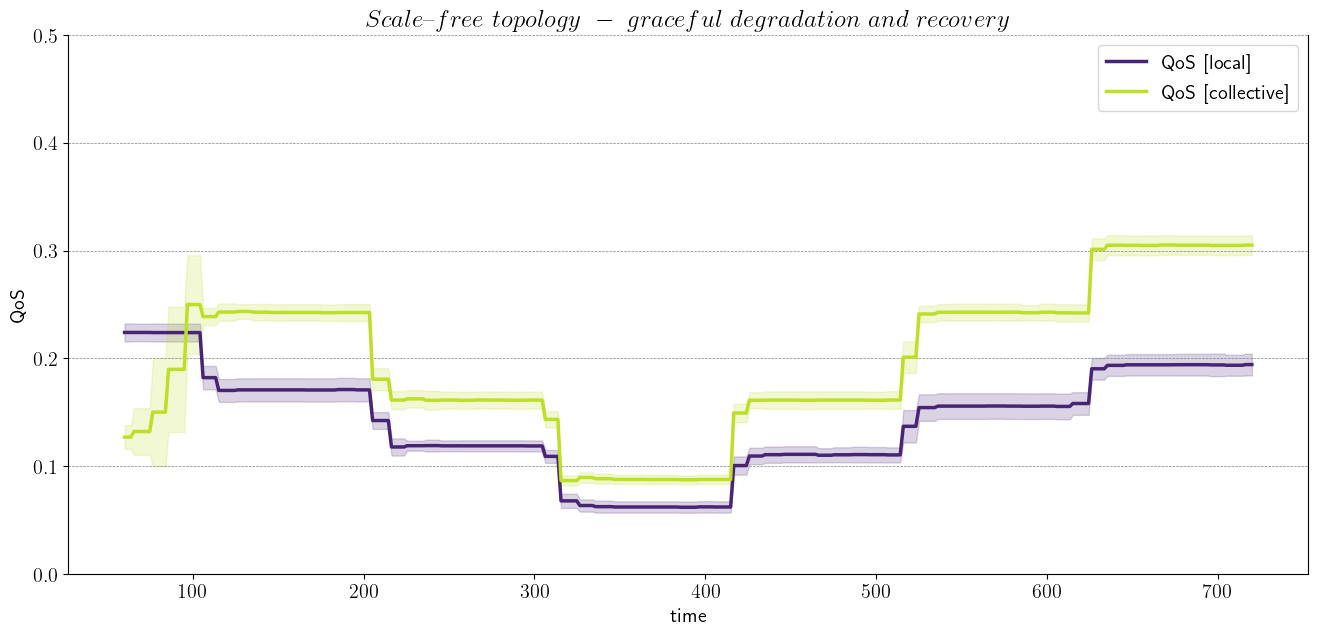

In [30]:
ax = barabasi_costant.plot(x="time", y=["QoS [local]", "QoS [collective]"], ylabel="QoS", figsize=(16, 7), ylim=(0, 0.5), colormap=lambda x: lammerda(cmx.viridis, x), linewidth=2.5)
ax.fill_between(time, simple_plus_errors_s1, simple_minus_errors_s1, alpha=0.2, color=lammerda(cmx.viridis, 0))
ax.fill_between(time, advanced_plus_errors_s1, advanced_minus_errors_s1, alpha=0.2, color=lammerda(cmx.viridis, 1))
ax.grid(axis = 'y', color = 'gray', linestyle = '--', linewidth = 0.5)
ax.spines['top'].set_visible(False)
ax.set_title(r"$Scale\textrm{--}free\ topology\ -\ graceful\ degradation\ and\ recovery$", fontsize=18)
plt.savefig("./charts/scale-free-degradation.svg", bbox_inches='tight')

In [31]:
(simple_values, simple_plus_errors_s3, simple_minus_errors_s3) = extract_values(lobster_short, lobster_short_stdevs, "simple", 3, 1000, 0)
(advanced_values, advanced_plus_errors_s3, advanced_minus_errors_s3) = extract_values(lobster_short, lobster_short_stdevs, "advanced", 3, 1000, 0)
load_driver = lobster_short.sel({"behavior": "simple", "computationalCost": 3, "devices": 1000, "load": 0 }, drop=True)["load[mean]"].to_numpy()
# effective_load = lobster_short.sel({"behavior": "simple", "computationalCost": 3, "devices": 1000, "load": 0 }, drop=True)["effectiveLoad[mean]"].to_numpy()
lobster_costant = pd.DataFrame({ "time": time, "QoS [static]": simple_values, "QoS [dynamic]": advanced_values, "Load driver": load_driver })
lobster_costant = lobster_costant.rename(columns={"QoS [static]": "QoS [local]", "QoS [dynamic]": "QoS [collective]"})

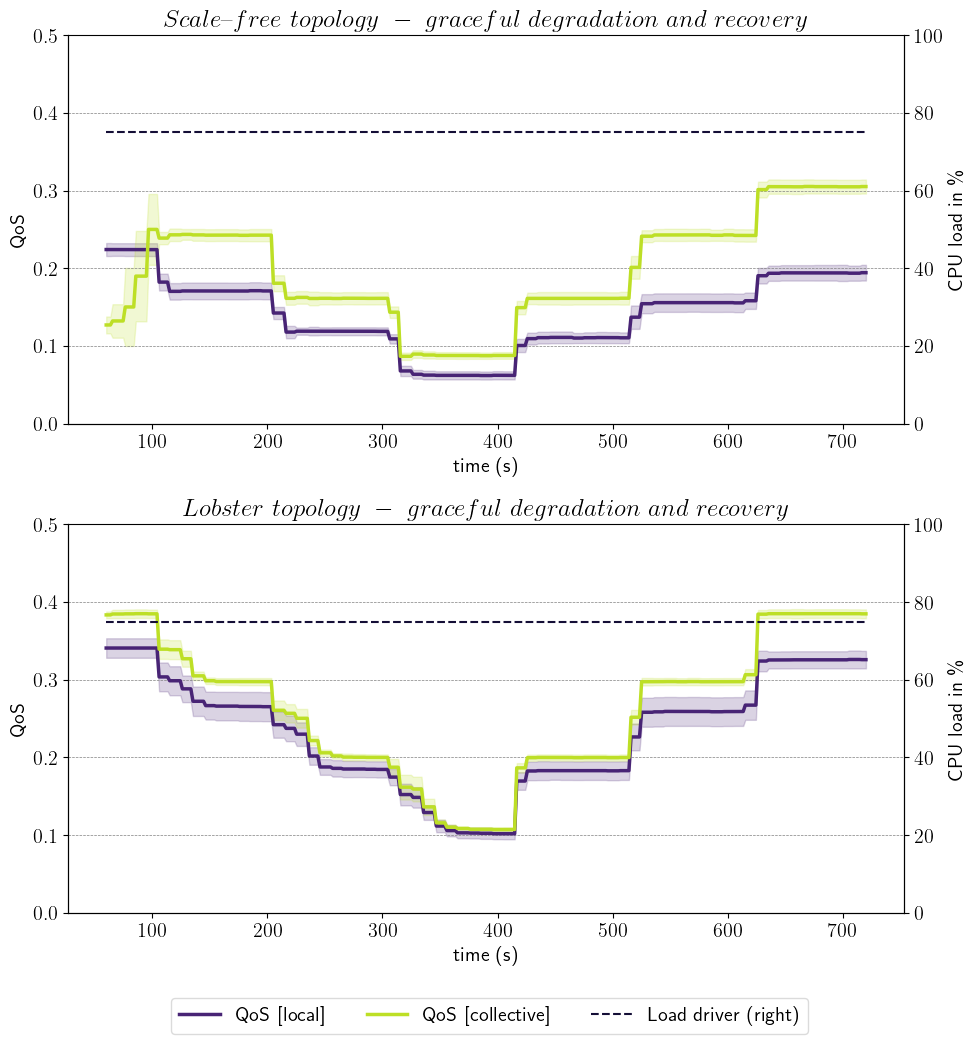

In [35]:
fig, axes = plt.subplots(2, 1)

ax = barabasi_costant.plot(x="time", ax=axes[0], y=["QoS [local]", "QoS [collective]"], ylabel="QoS", figsize=(10, 10), ylim=(0, 0.5), colormap=lambda x: lammerda(cmx.viridis, x), linewidth=2.5, legend=False)
barabasi_costant.plot(x="time", y=["Load driver"], ylabel=r"CPU load in \%", xlabel="time (s)", secondary_y = True, ax=ax, linestyle="dashed", ylim=(0, 100.05), colormap=lambda x: lammerda(cmx.magma, x), linewidth=1.5, legend=False)

ax.fill_between(time, simple_plus_errors_s1, simple_minus_errors_s1, alpha=0.2, color=lammerda(cmx.viridis, 0))
ax.fill_between(time, advanced_plus_errors_s1, advanced_minus_errors_s1, alpha=0.2, color=lammerda(cmx.viridis, 1))

ax.grid(axis = 'y', color = 'gray', linestyle = '--', linewidth = 0.5)
ax.spines['top'].set_visible(False)
ax.set_title(r"$Scale\textrm{--}free\ topology\ -\ graceful\ degradation\ and\ recovery$", fontsize=18)

ax = lobster_costant.plot(x="time", ax=axes[1], y=["QoS [local]", "QoS [collective]"], ylabel="QoS", figsize=(10, 10), ylim=(0, 0.5), colormap=lambda x: lammerda(cmx.viridis, x), linewidth=2.5, legend=False)
ax2 = lobster_costant.plot(x="time", y=["Load driver"], ylabel=r"CPU load in \%", xlabel="time (s)", secondary_y = True, ax=ax, linestyle="dashed", ylim=(0, 100.05), colormap=lambda x: lammerda(cmx.magma, x), linewidth=1.5, legend=False)

ax.fill_between(time, simple_plus_errors_s3, simple_minus_errors_s3, alpha=0.2, color=lammerda(cmx.viridis, 0))
ax.fill_between(time, advanced_plus_errors_s3, advanced_minus_errors_s3, alpha=0.2, color=lammerda(cmx.viridis, 1))

ax.grid(axis = 'y', color = 'gray', linestyle = '--', linewidth = 0.5)
ax.spines['top'].set_visible(False)
ax.set_title(r"$Lobster\ topology\ -\ graceful\ degradation\ and\ recovery$", fontsize=18)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines + lines2, labels + labels2, framealpha=0.7, loc=1, bbox_to_anchor=(0.83, 0), ncol=4)
plt.tight_layout()

plt.savefig("./charts/constant-load-vertical.pdf", bbox_inches='tight')

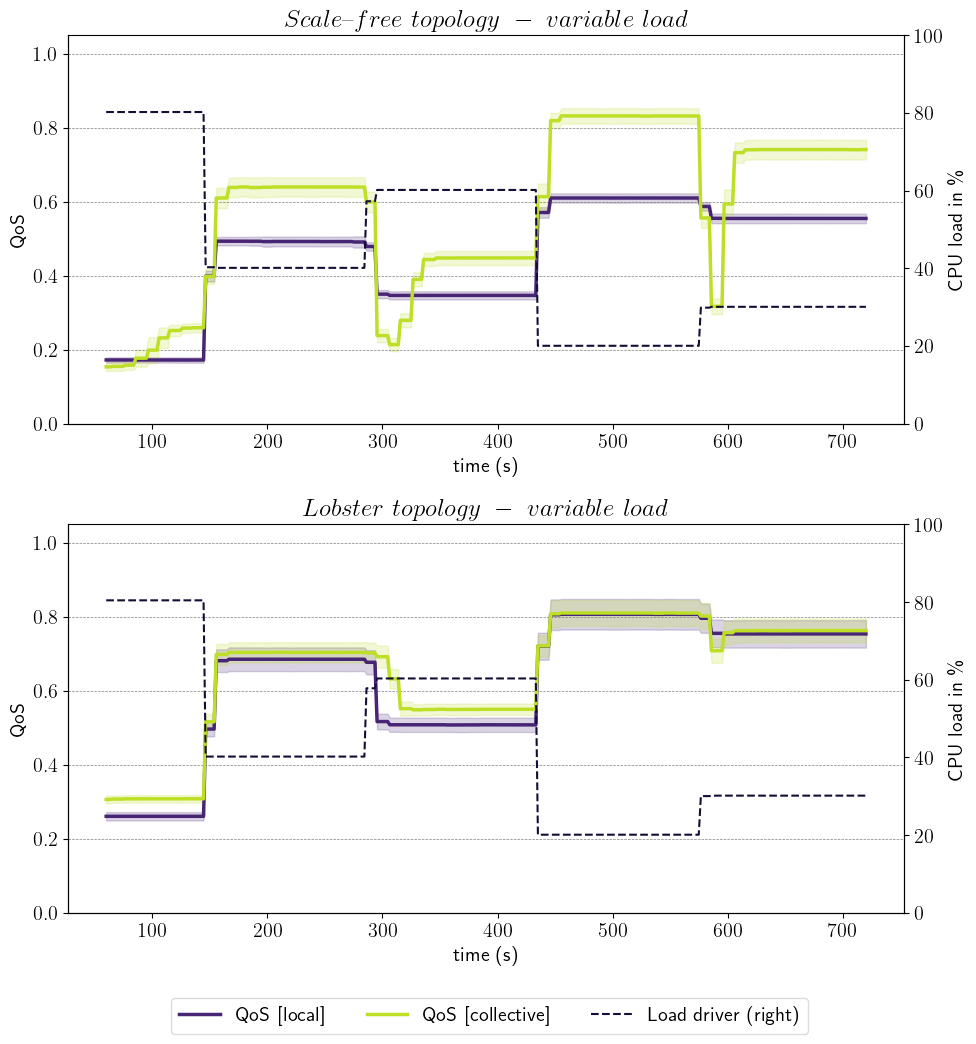

In [36]:
(simple_values, simple_plus_errors_s4, simple_minus_errors_s4) = extract_values(lobster_short, lobster_short_stdevs, "simple", 3, 1000, 1)
(advanced_values, advanced_plus_errors_s4, advanced_minus_errors_s4) = extract_values(lobster_short, lobster_short_stdevs, "advanced", 3, 1000, 1)
load_driver = lobster_short.sel({"behavior": "simple", "computationalCost": 3, "devices": 1000, "load": 1 }, drop=True)["load[mean]"].to_numpy()
# effective_load = lobster_short.sel({"behavior": "simple", "computationalCost": 3, "devices": 1000, "load": 1 }, drop=True)["effectiveLoad[mean]"].to_numpy()
lobster_dynamic = pd.DataFrame({ "time": time, "QoS [static]": simple_values, "QoS [dynamic]": advanced_values, "Load driver": load_driver })
lobster_dynamic = lobster_dynamic.rename(columns={"QoS [static]": "QoS [local]", "QoS [dynamic]": "QoS [collective]"})

(simple_values, simple_plus_errors_s2, simple_minus_errors_s2) = extract_values(barabasi_short, barabasi_short_stdevs, "simple", 3, 1000, 1)
(advanced_values, advanced_plus_errors_s2, advanced_minus_errors_s2) = extract_values(barabasi_short, barabasi_short_stdevs, "advanced", 3, 1000, 1)
load_driver = barabasi_short.sel({"behavior": "simple", "computationalCost": 3, "devices": 1000, "load": 1 }, drop=True)["load[mean]"].to_numpy()
# effective_load = barabasi_short.sel({"behavior": "simple", "computationalCost": 3, "devices": 1000, "load": 1 }, drop=True)["effectiveLoad[mean]"].to_numpy()
barabasi_dynamic = pd.DataFrame({ "time": time, "QoS [static]": simple_values, "QoS [dynamic]": advanced_values, "Load driver": load_driver })
barabasi_dynamic = barabasi_dynamic.rename(columns={"QoS [static]": "QoS [local]", "QoS [dynamic]": "QoS [collective]"})

fig, axes = plt.subplots(2, 1)

ax = barabasi_dynamic.plot(x="time", ax=axes[0], y=["QoS [local]", "QoS [collective]"], ylabel="QoS", figsize=(10, 10), ylim=(0, 1.05), colormap=lambda x: lammerda(cmx.viridis, x), linewidth=2.5, legend=False)
barabasi_dynamic.plot(x="time", y=["Load driver"], ylabel=r"CPU load in \%", xlabel="time (s)", secondary_y = True, ax=ax, linestyle="dashed", ylim=(0, 100.05), colormap=lambda x: lammerda(cmx.magma, x), linewidth=1.5, legend=False)

ax.fill_between(time, simple_plus_errors_s2, simple_minus_errors_s2, alpha=0.2, color=lammerda(cmx.viridis, 0))
ax.fill_between(time, advanced_plus_errors_s2, advanced_minus_errors_s2, alpha=0.2, color=lammerda(cmx.viridis, 1))

ax.grid(axis = 'y', color = 'gray', linestyle = '--', linewidth = 0.5)
ax.spines['top'].set_visible(False)
ax.set_title(r"$Scale\textrm{--}free\ topology\ -\ variable\ load$", fontsize=18)

ax = lobster_dynamic.plot(x="time", ax=axes[1], y=["QoS [local]", "QoS [collective]"], ylabel="QoS", figsize=(10, 10), ylim=(0, 1.05), colormap=lambda x: lammerda(cmx.viridis, x), linewidth=2.5, legend=False)
lobster_dynamic.plot(x="time", y=["Load driver"], ylabel=r"CPU load in \%", xlabel="time (s)", secondary_y = True, ax=ax, linestyle="dashed", ylim=(0, 100.05), colormap=lambda x: lammerda(cmx.magma, x), linewidth=1.5, legend=False)

ax.fill_between(time, simple_plus_errors_s4, simple_minus_errors_s4, alpha=0.2, color=lammerda(cmx.viridis, 0))
ax.fill_between(time, advanced_plus_errors_s4, advanced_minus_errors_s4, alpha=0.2, color=lammerda(cmx.viridis, 1))

ax.grid(axis = 'y', color = 'gray', linestyle = '--', linewidth = 0.5)
ax.spines['top'].set_visible(False)
ax.set_title(r"$Lobster\ topology\ -\ variable\ load$", fontsize=18)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines + lines2, labels + labels2, framealpha=0.7, loc=1, bbox_to_anchor=(0.83, 0), ncol=4)
plt.tight_layout()

plt.savefig("./charts/dynamic-load-vertical.pdf", bbox_inches='tight')